In [1]:
# !pip install koreanize-matplotlib
# !pip install plotly
# !pip install ta==0.9.0
# !pip install bayesian-optimization

## lib

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import ta

import os
from pylab import plt, mpl
from tqdm import tqdm
from datetime import datetime, timedelta
import random

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision

In [4]:
# import ta 
# from libs.feature_importance import importance as imp
from sklearn.metrics import classification_report, precision_score, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.feature_selection import SequentialFeatureSelector, RFECV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn') # 'seaborn-v0_8' 스타일을 사용 오류
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
pd.set_option('display.precision', 4)
np.set_printoptions(suppress=True, precision=4)
os.environ['PYTHONHASHSEED'] = '0'

In [5]:
import koreanize_matplotlib

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

#### seaborn 한글 깨짐 현상 해결 방법

In [6]:
# jupyter notebook 내 그래프를 바로 그리기 위한 설정
%matplotlib inline

# unicode minus를 사용하지 않기 위한 설정 (minus 깨짐현상 방지)
plt.rcParams['axes.unicode_minus'] = False

In [7]:
# # 주가데이터
# import FinanceDataReader as fdr
# fdr.__version__

### Seed 설정

In [8]:
import random

# 시드 값 설정
seed_value = 100

# 파이썬 내장 random 모듈 시드 설정
random.seed(seed_value)

# TensorFlow 시드 설정
tf.random.set_seed(seed_value)

# Numpy 시드 설정
np.random.seed(seed_value)

### 데이터 준비

In [9]:
kospi_14_24_01_trend_label_kalman = pd.read_csv('kospi_14_24_01_trend_label_kalman.csv', index_col=0)
kospi_14_24_01_trend_label_kalman.drop(columns=['순매수_전체'], inplace=True)
kospi_14_24_01_trend_label_kalman

,Open,High,Low,Close,Volume,MarCap,매도_금융투자,매수_금융투자,순매수_금융투자,매도_보험,...,매수_외국인,순매수_외국인,매도_기타외국인,매수_기타외국인,순매수_기타외국인,매도_전체,매수_전체,kalman_ma,target,r
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,1963.72,1964.63,1936.15,1946.14,188529402,1147185472603763,8370037,3672850,-4697187,2934571,...,19641945,-3241963,287135,275966,-11169,188529402,188529402,1308.6930,1.0,-0.0108
2014-01-06,1947.62,1961.85,1943.74,1953.28,193630493,1151821444321770,5916693,3625874,-2290819,2149348,...,18521901,-9687,309123,358130,49007,193630493,193630493,1475.0104,1.0,0.0037
2014-01-07,1947.65,1965.74,1947.08,1959.44,193026899,1155148368398739,4397282,2771893,-1625389,2631309,...,21741808,252863,403188,228783,-174405,193026899,193026899,1577.4043,1.0,0.0031
2014-01-08,1965.50,1966.95,1950.02,1958.96,217070410,1155336478303790,4820502,3505739,-1314763,1859109,...,21287974,1446823,625622,403195,-222427,217070410,217070410,1646.5602,1.0,-0.0002
2014-01-09,1962.30,1964.59,1946.11,1946.11,276402210,1147927559250180,10563357,3576175,-6987182,2885453,...,27180214,3585598,513344,511831,-1513,276402210,276402210,1694.6511,1.0,-0.0066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29,2675.46,2687.44,2665.21,2687.44,470546033,2189691725743463,5353046,10015015,4661969,1479298,...,86286386,17320111,1381707,1298537,-83170,470546033,470546033,2664.2192,1.0,0.0116
2024-04-30,2693.22,2710.23,2687.29,2692.06,460083516,2193843858061216,6073768,9027473,2953705,1548253,...,93844715,9691247,1417945,1524896,106951,460083516,460083516,2666.8676,1.0,0.0017
2024-05-02,2679.04,2692.47,2678.84,2683.65,351087270,2186876849586271,7429768,4868198,-2561570,1366408,...,66236931,-2769990,869053,1001788,132735,351087270,351087270,2668.4640,1.0,-0.0031


### 기술적 지표 추가

In [10]:
data = kospi_14_24_01_trend_label_kalman[['Open', 'High', 'Low', 'Close', 'Volume']]

In [11]:
mt = 1
fillna = False
df_ = data.copy()
open, high, low, close, volume = 'Open', 'High', 'Low', 'Close', 'Volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

### 거래량 관련 지표 추가

In [12]:
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.Volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.Close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.Close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.Volume.rolling(i).std()

In [13]:
df_.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'volume_cmf', 'volume_fi',
       'volume_mfi', 'volume_sma_em', 'volume_vpt', 'volatility_atr',
       'volatility_ui', 'trend_macd_diff', 'trend_adx', 'trend_trix',
       'trend_mass_index', 'trend_dpo', 'trend_aroon_ind', 'momentum_rsi',
       'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10', 'ret_10',
       'vol_change_20', 'ret_20', 'std_30', 'vol_std_30'],
      dtype='object')

In [14]:
selected_TI = df_[['volume_cmf', 'volume_fi',
                   'volume_mfi', 'volume_sma_em', 'volume_vpt', 'volatility_atr',
                   'volatility_ui', 'trend_macd_diff', 'trend_adx', 'trend_trix',
                   'trend_mass_index', 'trend_dpo', 'trend_aroon_ind', 'momentum_rsi',
                   'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10', 'ret_10',
                   'vol_change_20', 'ret_20', 'std_30', 'vol_std_30']]

In [15]:
kospi_14_24_01_trend_label_kalman_ta = pd.concat([kospi_14_24_01_trend_label_kalman, selected_TI], axis=1)
kospi_14_24_01_trend_label_kalman_ta.dropna(inplace=True)
kospi_14_24_01_trend_label_kalman_ta

,Open,High,Low,Close,Volume,MarCap,매도_금융투자,매수_금융투자,순매수_금융투자,매도_보험,...,momentum_rsi,momentum_wr,vol_change_5,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-07,1979.70,1983.53,1968.66,1974.68,231557237,1171060533144157,3586232,4040200,453968,2641596,...,58.2840,-15.8036,-0.0841,-0.0027,0.0705,0.0086,-0.1517,0.0271,25.1396,3.2223e+07
2014-03-10,1967.63,1967.66,1951.96,1954.42,214944284,1159472445620989,4957687,3914211,-1043476,3045944,...,50.5248,-51.9821,-0.0345,-0.0052,0.1090,0.0028,0.0336,0.0162,25.2254,3.2323e+07
2014-03-11,1957.22,1963.87,1951.20,1963.87,247468004,1164815467875309,3837210,4029193,191983,3804816,...,53.6111,-35.1071,0.2351,0.0050,0.0948,-0.0005,0.0931,0.0165,25.5382,3.1099e+07
2014-03-12,1957.67,1958.09,1930.48,1932.54,329923547,1146460580210853,6588397,7599838,1011441,3966236,...,43.8865,-91.0536,0.6688,-0.0196,0.5775,-0.0194,0.4639,-0.0017,24.8807,2.9814e+07
2014-03-13,1940.35,1946.28,1931.75,1934.38,259619849,1147366863530616,5901313,6934734,1033421,2884637,...,44.5197,-92.6484,0.3400,-0.0209,0.2913,-0.0223,0.3820,0.0039,24.4391,2.9330e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29,2675.46,2687.44,2665.21,2687.44,470546033,2189691725743463,5353046,10015015,4661969,1479298,...,52.5648,-28.6605,0.1708,0.0221,-0.1627,0.0064,-0.0504,-0.0215,53.2771,1.2649e+08
2024-04-30,2693.22,2710.23,2687.29,2692.06,460083516,2193843858061216,6073768,9027473,2953705,1548253,...,53.1227,-26.1988,0.0693,0.0263,-0.1931,0.0316,0.1572,-0.0203,53.2664,1.2521e+08
2024-05-02,2679.04,2692.47,2678.84,2683.65,351087270,2186876849586271,7429768,4868198,-2561570,1366408,...,51.9315,-20.9215,0.0778,0.0030,-0.1527,0.0385,-0.4431,-0.0252,52.8690,1.2483e+08


### 주식 시장 지표 (Market Indices) 추가

In [16]:
# Load the uploaded data
market_indices = pd.read_csv('MarketIndices.csv')

# Convert the 'Date' column to datetime
market_indices['Date'] = pd.to_datetime(market_indices['Date'])
kospi_14_24_01_trend_label_kalman_ta.index = pd.to_datetime(kospi_14_24_01_trend_label_kalman_ta.index)

# Extract 'Adj Close' values and 'Index' for the first dataset
adj_close_indices = market_indices.pivot(index='Date', columns='Index', values='Adj Close')

# Shift the 'Adj Close' values by one day
adj_close_indices_shifted = adj_close_indices.shift(1)

# Merge the shifted 'Adj Close' values with the second dataset
merged_df = kospi_14_24_01_trend_label_kalman_ta.join(adj_close_indices_shifted, how='left') # 컬럼을 명시하지 않으면 인덱스를 기준으로 조인

# Fill NaN values in the new features with the previous day's values
merged_df = merged_df.fillna(method='ffill') # forward fill

# Drop the 'kosdaq', 'kospi', 'kospi200' columns from the merged dataframe
kospi_14_24_01_trend_label_kalman_ta_MI = merged_df.drop(columns=['kosdaq', 'kospi', 'kospi200'])
kospi_14_24_01_trend_label_kalman_ta_MI

,Open,High,Low,Close,Volume,MarCap,매도_금융투자,매수_금융투자,순매수_금융투자,매도_보험,...,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,dowjones,nasdaq,s&p500
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-07,1979.70,1983.53,1968.66,1974.68,231557237,1171060533144157,3586232,4040200,453968,2641596,...,-0.0027,0.0705,0.0086,-0.1517,0.0271,25.1396,3.2223e+07,16421.8906,4352.1299,1877.0300
2014-03-10,1967.63,1967.66,1951.96,1954.42,214944284,1159472445620989,4957687,3914211,-1043476,3045944,...,-0.0052,0.1090,0.0028,0.0336,0.0162,25.2254,3.2323e+07,16452.7207,4336.2202,1878.0400
2014-03-11,1957.22,1963.87,1951.20,1963.87,247468004,1164815467875309,3837210,4029193,191983,3804816,...,0.0050,0.0948,-0.0005,0.0931,0.0165,25.5382,3.1099e+07,16418.6797,4334.4502,1877.1700
2014-03-12,1957.67,1958.09,1930.48,1932.54,329923547,1146460580210853,6588397,7599838,1011441,3966236,...,-0.0196,0.5775,-0.0194,0.4639,-0.0017,24.8807,2.9814e+07,16351.2500,4307.1899,1867.6300
2014-03-13,1940.35,1946.28,1931.75,1934.38,259619849,1147366863530616,5901313,6934734,1033421,2884637,...,-0.0209,0.2913,-0.0223,0.3820,0.0039,24.4391,2.9330e+07,16340.0801,4323.3301,1868.2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29,2675.46,2687.44,2665.21,2687.44,470546033,2189691725743463,5353046,10015015,4661969,1479298,...,0.0221,-0.1627,0.0064,-0.0504,-0.0215,53.2771,1.2649e+08,38239.6602,15927.9004,5099.9600
2024-04-30,2693.22,2710.23,2687.29,2692.06,460083516,2193843858061216,6073768,9027473,2953705,1548253,...,0.0263,-0.1931,0.0316,0.1572,-0.0203,53.2664,1.2521e+08,38386.0898,15983.0801,5116.1699
2024-05-02,2679.04,2692.47,2678.84,2683.65,351087270,2186876849586271,7429768,4868198,-2561570,1366408,...,0.0030,-0.1527,0.0385,-0.4431,-0.0252,52.8690,1.2483e+08,37903.2891,15605.4805,5018.3901


In [17]:
kospi_14_24_01_trend_label_kalman_ta_MI.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MarCap', '매도_금융투자',
       '매수_금융투자', '순매수_금융투자', '매도_보험', '매수_보험', '순매수_보험', '매도_투신', '매수_투신',
       '순매수_투신', '매도_사모', '매수_사모', '순매수_사모', '매도_은행', '매수_은행', '순매수_은행',
       '매도_기타금융', '매수_기타금융', '순매수_기타금융', '매도_연기금 등', '매수_연기금 등', '순매수_연기금 등',
       '매도_기관합계', '매수_기관합계', '순매수_기관합계', '매도_기타법인', '매수_기타법인', '순매수_기타법인',
       '매도_개인', '매수_개인', '순매수_개인', '매도_외국인', '매수_외국인', '순매수_외국인', '매도_기타외국인',
       '매수_기타외국인', '순매수_기타외국인', '매도_전체', '매수_전체', 'kalman_ma', 'target', 'r',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_sma_em', 'volume_vpt',
       'volatility_atr', 'volatility_ui', 'trend_macd_diff', 'trend_adx',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_aroon_ind',
       'momentum_rsi', 'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10',
       'ret_10', 'vol_change_20', 'ret_20', 'std_30', 'vol_std_30', 'dowjones',
       'nasdaq', 's&p500'],
      dtype='object')

### Scaling 전 데이터 split

In [18]:
# 학습 및 검증 데이터와 테스트 데이터로 분할
df_train = kospi_14_24_01_trend_label_kalman_ta_MI[kospi_14_24_01_trend_label_kalman_ta_MI.index < '2023-05-01']
df_test = kospi_14_24_01_trend_label_kalman_ta_MI[kospi_14_24_01_trend_label_kalman_ta_MI.index >= '2023-05-01']

In [19]:
df_train

,Open,High,Low,Close,Volume,MarCap,매도_금융투자,매수_금융투자,순매수_금융투자,매도_보험,...,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,dowjones,nasdaq,s&p500
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-07,1979.70,1983.53,1968.66,1974.68,231557237,1171060533144157,3586232,4040200,453968,2641596,...,-0.0027,0.0705,0.0086,-0.1517,0.0271,25.1396,3.2223e+07,16421.8906,4352.1299,1877.0300
2014-03-10,1967.63,1967.66,1951.96,1954.42,214944284,1159472445620989,4957687,3914211,-1043476,3045944,...,-0.0052,0.1090,0.0028,0.0336,0.0162,25.2254,3.2323e+07,16452.7207,4336.2202,1878.0400
2014-03-11,1957.22,1963.87,1951.20,1963.87,247468004,1164815467875309,3837210,4029193,191983,3804816,...,0.0050,0.0948,-0.0005,0.0931,0.0165,25.5382,3.1099e+07,16418.6797,4334.4502,1877.1700
2014-03-12,1957.67,1958.09,1930.48,1932.54,329923547,1146460580210853,6588397,7599838,1011441,3966236,...,-0.0196,0.5775,-0.0194,0.4639,-0.0017,24.8807,2.9814e+07,16351.2500,4307.1899,1867.6300
2014-03-13,1940.35,1946.28,1931.75,1934.38,259619849,1147366863530616,5901313,6934734,1033421,2884637,...,-0.0209,0.2913,-0.0223,0.3820,0.0039,24.4391,2.9330e+07,16340.0801,4323.3301,1868.2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,2538.36,2541.89,2518.73,2523.50,927191299,1996621732458125,10338951,13755734,3416783,774621,...,-0.0203,0.2920,0.0045,0.9609,0.0474,71.6277,2.0873e+08,33808.9609,12072.4600,4133.5200
2023-04-25,2531.35,2531.35,2472.33,2489.02,886421798,1967147727128900,14057882,13270372,-787510,1056405,...,-0.0319,0.1539,-0.0231,0.6916,0.0222,67.6065,2.0974e+08,33875.3984,12037.2002,4137.0400
2023-04-26,2489.49,2498.56,2481.38,2484.83,1089215527,1964553908314712,11861945,10170758,-1691187,1109120,...,-0.0350,0.2092,-0.0258,1.1906,0.0167,64.9391,2.1791e+08,33530.8281,11799.1602,4071.6299


In [20]:
df_test

,Open,High,Low,Close,Volume,MarCap,매도_금융투자,매수_금융투자,순매수_금융투자,매도_보험,...,ret_5,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,dowjones,nasdaq,s&p500
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-02,2504.01,2524.42,2503.21,2524.39,701398536,1997496492608915,9416649,13971329,4554680,918678,...,0.0004,-0.0958,-0.0200,-0.1359,0.0211,55.9201,1.8178e+08,34051.6992,12212.5996,4167.8701
2023-05-03,2510.19,2514.37,2497.83,2501.40,889609358,1979410344840207,11407984,8023058,-3384926,1014087,...,0.0050,-0.0082,-0.0271,0.0685,0.0084,52.1613,1.6868e+08,33684.5312,12080.5098,4119.5801
2023-05-04,2494.82,2502.14,2486.09,2500.94,810178245,1978572080421787,16577707,10779894,-5797813,2842450,...,0.0065,-0.1534,-0.0288,0.2805,0.0023,49.8147,1.6190e+08,33414.2383,12025.3301,4090.7500
2023-05-08,2518.53,2525.84,2511.13,2513.21,655536077,1989045053273087,6595212,14395063,7799851,1254688,...,0.0070,-0.3110,-0.0195,-0.1276,0.0220,47.6615,1.5895e+08,33674.3789,12235.4102,4136.2500
2023-05-09,2512.34,2514.81,2495.63,2510.06,751646926,1986578323550486,7504268,8686771,1182503,1073048,...,0.0034,-0.2254,-0.0135,0.2805,0.0079,44.5535,1.4870e+08,33618.6914,12256.9199,4138.1201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29,2675.46,2687.44,2665.21,2687.44,470546033,2189691725743463,5353046,10015015,4661969,1479298,...,0.0221,-0.1627,0.0064,-0.0504,-0.0215,53.2771,1.2649e+08,38239.6602,15927.9004,5099.9600
2024-04-30,2693.22,2710.23,2687.29,2692.06,460083516,2193843858061216,6073768,9027473,2953705,1548253,...,0.0263,-0.1931,0.0316,0.1572,-0.0203,53.2664,1.2521e+08,38386.0898,15983.0801,5116.1699
2024-05-02,2679.04,2692.47,2678.84,2683.65,351087270,2186876849586271,7429768,4868198,-2561570,1366408,...,0.0030,-0.1527,0.0385,-0.4431,-0.0252,52.8690,1.2483e+08,37903.2891,15605.4805,5018.3901


### Train Data Scaling

In [21]:
scaler = RobustScaler() # StandardScaler  RobustScaler
X_features = df_train.columns.values[~(df_train.columns.values == 'target')]
scaled_features = scaler.fit_transform(df_train.loc[:, X_features])
df_train_scaled = pd.DataFrame(scaled_features, index=df_train.index, columns=df_train.loc[:, X_features].columns)
df_train_scaled['target'] = df_train['target']
df_train_scaled

,Open,High,Low,Close,Volume,MarCap,매도_금융투자,매수_금융투자,순매수_금융투자,매도_보험,...,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,dowjones,nasdaq,s&p500,target
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-07,-0.4666,-0.4730,-0.4641,-0.4725,-0.6616,-0.5339,-0.6351,-0.5345,0.1504,0.6048,...,0.1630,0.1854,-0.3675,0.4594,-0.3537,-0.8335,-0.7048,-0.5115,-0.5504,-1.0
2014-03-10,-0.4945,-0.5093,-0.5030,-0.5196,-0.7152,-0.5558,-0.4186,-0.5536,-0.2199,0.9693,...,0.2574,0.0250,0.0553,0.2382,-0.3507,-0.8323,-0.7023,-0.5141,-0.5497,-1.0
2014-03-11,-0.5186,-0.5180,-0.5048,-0.4976,-0.6103,-0.5457,-0.5954,-0.5361,0.0856,1.6533,...,0.2226,-0.0644,0.1912,0.2439,-0.3400,-0.8469,-0.7051,-0.5144,-0.5503,-1.0
2014-03-12,-0.5175,-0.5312,-0.5531,-0.5704,-0.3443,-0.5804,-0.1611,0.0072,0.2882,1.7988,...,1.4044,-0.5825,1.0374,-0.1230,-0.3625,-0.8623,-0.7107,-0.5189,-0.5563,-1.0
2014-03-13,-0.5575,-0.5582,-0.5501,-0.5661,-0.5711,-0.5786,-0.2696,-0.0940,0.2936,0.8239,...,0.7037,-0.6611,0.8505,-0.0108,-0.3777,-0.8682,-0.7116,-0.5162,-0.5559,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,0.8245,0.8045,0.8181,0.8026,1.5824,1.0235,0.4310,0.9440,0.8830,-1.0779,...,0.7054,0.0741,2.1716,0.8691,1.2420,1.2822,0.7346,0.7606,0.8725,-1.0
2023-04-25,0.8083,0.7803,0.7100,0.7225,1.4509,0.9679,1.0180,0.8701,-0.1566,-0.8240,...,0.3674,-0.6838,1.5570,0.3599,1.1040,1.2943,0.7401,0.7548,0.8747,-1.0
2023-04-26,0.7116,0.7053,0.7310,0.7127,2.1051,0.9630,0.6714,0.3984,-0.3801,-0.7764,...,0.5028,-0.7580,2.6959,0.2494,1.0124,1.3923,0.7116,0.7155,0.8335,-1.0


### Test Data Scaling

In [22]:
scaled_features = scaler.transform(df_test.loc[:, X_features])
df_test_scaled = pd.DataFrame(scaled_features, index=df_test.index, columns=df_test.loc[:, X_features].columns)
df_test_scaled['target'] = df_test['target']
df_test_scaled

,Open,High,Low,Close,Volume,MarCap,매도_금융투자,매수_금융투자,순매수_금융투자,매도_보험,...,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,dowjones,nasdaq,s&p500,target
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-02,0.7452,0.7645,0.7819,0.8047,0.8540,1.0251,0.2854,0.9768,1.1644,-0.9481,...,-0.2442,-0.5990,-0.3315,0.3365,0.7029,0.9592,0.7547,0.7837,0.8941,-1.0
2023-05-03,0.7594,0.7415,0.7694,0.7512,1.4612,0.9910,0.5997,0.0716,-0.7989,-0.8621,...,-0.0295,-0.7938,0.1351,0.0815,0.5739,0.8022,0.7243,0.7619,0.8637,-1.0
2023-05-04,0.7239,0.7135,0.7420,0.7502,1.2050,0.9894,1.4158,0.4911,-1.3955,0.7859,...,-0.3852,-0.8400,0.6188,-0.0422,0.4933,0.7209,0.7019,0.7528,0.8455,-1.0
2023-05-08,0.7787,0.7677,0.8004,0.7787,0.7061,1.0092,-0.1601,1.0412,1.9668,-0.6452,...,-0.7710,-0.5844,-0.3124,0.3546,0.4194,0.6855,0.7234,0.7874,0.8742,-1.0
2023-05-09,0.7644,0.7425,0.7643,0.7714,1.0161,1.0045,-0.0165,0.1726,0.3305,-0.8090,...,-0.5615,-0.4206,0.6188,0.0708,0.3127,0.5627,0.7188,0.7910,0.8754,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29,1.1414,1.1375,1.1595,1.1835,0.1093,1.3877,-0.3561,0.3747,1.1909,-0.4428,...,-0.4078,0.1241,-0.1363,-0.5236,0.6122,0.2965,1.1014,1.3958,1.4819,1.0
2024-04-30,1.1825,1.1896,1.2110,1.1942,0.0756,1.3955,-0.2424,0.2245,0.7685,-0.3806,...,-0.4824,0.8155,0.3373,-0.4985,0.6118,0.2811,1.1135,1.4049,1.4921,1.0
2024-05-02,1.1497,1.1490,1.1913,1.1747,-0.2760,1.3824,-0.0283,-0.4085,-0.5953,-0.5445,...,-0.3834,1.0048,-1.0325,-0.5982,0.5981,0.2766,1.0735,1.3427,1.4304,1.0


### Data Analysis

In [23]:
# 전체 컬럼
df_train_scaled.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MarCap', '매도_금융투자',
       '매수_금융투자', '순매수_금융투자', '매도_보험', '매수_보험', '순매수_보험', '매도_투신', '매수_투신',
       '순매수_투신', '매도_사모', '매수_사모', '순매수_사모', '매도_은행', '매수_은행', '순매수_은행',
       '매도_기타금융', '매수_기타금융', '순매수_기타금융', '매도_연기금 등', '매수_연기금 등', '순매수_연기금 등',
       '매도_기관합계', '매수_기관합계', '순매수_기관합계', '매도_기타법인', '매수_기타법인', '순매수_기타법인',
       '매도_개인', '매수_개인', '순매수_개인', '매도_외국인', '매수_외국인', '순매수_외국인', '매도_기타외국인',
       '매수_기타외국인', '순매수_기타외국인', '매도_전체', '매수_전체', 'kalman_ma', 'r',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_sma_em', 'volume_vpt',
       'volatility_atr', 'volatility_ui', 'trend_macd_diff', 'trend_adx',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_aroon_ind',
       'momentum_rsi', 'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10',
       'ret_10', 'vol_change_20', 'ret_20', 'std_30', 'vol_std_30', 'dowjones',
       'nasdaq', 's&p500', 'target'],
      dtype='object')

- 순매수 합계 제거된 피쳐

['매도_금융투자', '매수_금융투자', '매도_보험', '매수_보험', '매도_투신', '매수_투신', 
                  '매도_사모', '매수_사모', '매도_은행', '매수_은행', '매도_기타금융', '매수_기타금융', 
                  '매도_연기금 등', '매수_연기금 등', '매도_기타법인', '매수_기타법인', '매도_개인', '매수_개인', 
                  '매도_외국인', '매수_외국인', '매도_기타외국인', '매수_기타외국인', 
                  'Date', 'Open', 'High', 'Low', 'Close', 'r']

- 기술적 지표 피쳐

['volume_cmf', 'volume_fi', 'volume_mfi', 'volume_sma_em', 'volume_vpt',
 'volatility_atr', 'volatility_ui', 'trend_macd_diff', 'trend_adx',
 'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_aroon_ind',
 'momentum_rsi', 'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10',
 'ret_10', 'vol_change_20', 'ret_20', 'std_30', 'vol_std_30']

- 시장 지표

['dowjones', 'nasdaq', 's&p500']

In [24]:
# 타겟값의 비율
df_train_scaled['target'].value_counts(1)

 1.0    0.5511
-1.0    0.4489
Name: target, dtype: float64

In [25]:
# 타겟값의 비율
df_test_scaled['target'].value_counts(1)

 1.0    0.5726
-1.0    0.4274
Name: target, dtype: float64

### Test Set을 제외한 상관관계 분석

In [26]:
# df_corr = df_train_scaled.copy()

# # target 값을 다음날 값으로 가져온다.
# df_corr['target'] = df_corr['target'].shift(-1)
# df_corr.dropna(inplace=True)

In [27]:
# # # 피쳐 선택
# # variables = ['transaction_real_price', 'exclusive_use_area', 'floor', 'adjusted_year_of_completion', 'lat', 'long', 'park_min', 'kind_min',
# #              'subway_min', 'elem_min']

# # 상관관계 행렬 계산
# corr = df_corr.corr()

# # Heatmap으로 시각화
# plt.figure(figsize=(25, 25))
# sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
# plt.title('Correlation')
# plt.xticks(rotation=60)  # x 축 눈금값을 45도 기울임

# plt.show()

In [28]:
# corr['target'].sort_values(ascending = False)[1:].head(20)

In [29]:
# corr['target'].sort_values(ascending = False)[1:].tail(20)

### Test Set을 제외한 정규화 상호 정보 (Normalized Mutual Information, NMI)

In [30]:
# from sklearn.metrics import normalized_mutual_info_score

# # 정규화 상호 정보 계산
# nmi_matrix = pd.DataFrame(index=df_corr.columns, columns=df_corr.columns)

# for col1 in tqdm(df_corr.columns):
#     for col2 in df_corr.columns:
#         nmi = normalized_mutual_info_score(df_corr[col1], df_corr[col2])
#         nmi_matrix.loc[col1, col2] = nmi

# nmi_matrix = nmi_matrix.astype(float)

# # 시각화
# plt.figure(figsize=(25, 25))
# sns.heatmap(nmi_matrix, annot=True, cmap='viridis', fmt=".2f")
# plt.title('Normalized Mutual Information Matrix')
# plt.show()

In [31]:
# # 'target' 컬럼과 나머지 변수 간의 정규화 상호 정보 계산
# nmi_values = {}

# target_col = 'target'
# for col in tqdm(df_corr.columns):
#     if col != target_col:
#         nmi = normalized_mutual_info_score(df_corr[target_col], df_corr[col])
#         nmi_values[col] = nmi

# # 데이터프레임으로 변환
# nmi_df = pd.DataFrame.from_dict(nmi_values, orient='index', columns=['NMI'])
# nmi_df.sort_values(by='NMI', ascending=False, inplace=True)

# # 시각화
# plt.figure(figsize=(10, 6))
# sns.barplot(x=nmi_df.index, y='NMI', data=nmi_df, palette='viridis')
# plt.title('Normalized Mutual Information with Target')
# plt.xlabel('Features')
# plt.ylabel('NMI')
# plt.xticks(rotation=90)
# plt.show()

## 변수 선택

In [32]:
df_train_scaled.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MarCap', '매도_금융투자',
       '매수_금융투자', '순매수_금융투자', '매도_보험', '매수_보험', '순매수_보험', '매도_투신', '매수_투신',
       '순매수_투신', '매도_사모', '매수_사모', '순매수_사모', '매도_은행', '매수_은행', '순매수_은행',
       '매도_기타금융', '매수_기타금융', '순매수_기타금융', '매도_연기금 등', '매수_연기금 등', '순매수_연기금 등',
       '매도_기관합계', '매수_기관합계', '순매수_기관합계', '매도_기타법인', '매수_기타법인', '순매수_기타법인',
       '매도_개인', '매수_개인', '순매수_개인', '매도_외국인', '매수_외국인', '순매수_외국인', '매도_기타외국인',
       '매수_기타외국인', '순매수_기타외국인', '매도_전체', '매수_전체', 'kalman_ma', 'r',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_sma_em', 'volume_vpt',
       'volatility_atr', 'volatility_ui', 'trend_macd_diff', 'trend_adx',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_aroon_ind',
       'momentum_rsi', 'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10',
       'ret_10', 'vol_change_20', 'ret_20', 'std_30', 'vol_std_30', 'dowjones',
       'nasdaq', 's&p500', 'target'],
      dtype='object')

In [33]:
# 제거하고 싶은 피쳐
removed_features = [] 

In [34]:
train_data_ = df_train_scaled.copy()
train_data_ = train_data_.drop(columns=removed_features)
train_data_['target'] = train_data_['target'].apply(lambda x: 1 if x > 0 else 0)
train_data_

,Open,High,Low,Close,Volume,MarCap,매도_금융투자,매수_금융투자,순매수_금융투자,매도_보험,...,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,dowjones,nasdaq,s&p500,target
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-07,-0.4666,-0.4730,-0.4641,-0.4725,-0.6616,-0.5339,-0.6351,-0.5345,0.1504,0.6048,...,0.1630,0.1854,-0.3675,0.4594,-0.3537,-0.8335,-0.7048,-0.5115,-0.5504,0
2014-03-10,-0.4945,-0.5093,-0.5030,-0.5196,-0.7152,-0.5558,-0.4186,-0.5536,-0.2199,0.9693,...,0.2574,0.0250,0.0553,0.2382,-0.3507,-0.8323,-0.7023,-0.5141,-0.5497,0
2014-03-11,-0.5186,-0.5180,-0.5048,-0.4976,-0.6103,-0.5457,-0.5954,-0.5361,0.0856,1.6533,...,0.2226,-0.0644,0.1912,0.2439,-0.3400,-0.8469,-0.7051,-0.5144,-0.5503,0
2014-03-12,-0.5175,-0.5312,-0.5531,-0.5704,-0.3443,-0.5804,-0.1611,0.0072,0.2882,1.7988,...,1.4044,-0.5825,1.0374,-0.1230,-0.3625,-0.8623,-0.7107,-0.5189,-0.5563,0
2014-03-13,-0.5575,-0.5582,-0.5501,-0.5661,-0.5711,-0.5786,-0.2696,-0.0940,0.2936,0.8239,...,0.7037,-0.6611,0.8505,-0.0108,-0.3777,-0.8682,-0.7116,-0.5162,-0.5559,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,0.8245,0.8045,0.8181,0.8026,1.5824,1.0235,0.4310,0.9440,0.8830,-1.0779,...,0.7054,0.0741,2.1716,0.8691,1.2420,1.2822,0.7346,0.7606,0.8725,0
2023-04-25,0.8083,0.7803,0.7100,0.7225,1.4509,0.9679,1.0180,0.8701,-0.1566,-0.8240,...,0.3674,-0.6838,1.5570,0.3599,1.1040,1.2943,0.7401,0.7548,0.8747,0
2023-04-26,0.7116,0.7053,0.7310,0.7127,2.1051,0.9630,0.6714,0.3984,-0.3801,-0.7764,...,0.5028,-0.7580,2.6959,0.2494,1.0124,1.3923,0.7116,0.7155,0.8335,0


In [35]:
test_data_ = df_test_scaled.copy()
test_data_ = test_data_.drop(columns=removed_features)
test_data_['target'] = test_data_['target'].apply(lambda x: 1 if x > 0 else 0)
test_data_

,Open,High,Low,Close,Volume,MarCap,매도_금융투자,매수_금융투자,순매수_금융투자,매도_보험,...,vol_change_10,ret_10,vol_change_20,ret_20,std_30,vol_std_30,dowjones,nasdaq,s&p500,target
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-02,0.7452,0.7645,0.7819,0.8047,0.8540,1.0251,0.2854,0.9768,1.1644,-0.9481,...,-0.2442,-0.5990,-0.3315,0.3365,0.7029,0.9592,0.7547,0.7837,0.8941,0
2023-05-03,0.7594,0.7415,0.7694,0.7512,1.4612,0.9910,0.5997,0.0716,-0.7989,-0.8621,...,-0.0295,-0.7938,0.1351,0.0815,0.5739,0.8022,0.7243,0.7619,0.8637,0
2023-05-04,0.7239,0.7135,0.7420,0.7502,1.2050,0.9894,1.4158,0.4911,-1.3955,0.7859,...,-0.3852,-0.8400,0.6188,-0.0422,0.4933,0.7209,0.7019,0.7528,0.8455,0
2023-05-08,0.7787,0.7677,0.8004,0.7787,0.7061,1.0092,-0.1601,1.0412,1.9668,-0.6452,...,-0.7710,-0.5844,-0.3124,0.3546,0.4194,0.6855,0.7234,0.7874,0.8742,0
2023-05-09,0.7644,0.7425,0.7643,0.7714,1.0161,1.0045,-0.0165,0.1726,0.3305,-0.8090,...,-0.5615,-0.4206,0.6188,0.0708,0.3127,0.5627,0.7188,0.7910,0.8754,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29,1.1414,1.1375,1.1595,1.1835,0.1093,1.3877,-0.3561,0.3747,1.1909,-0.4428,...,-0.4078,0.1241,-0.1363,-0.5236,0.6122,0.2965,1.1014,1.3958,1.4819,1
2024-04-30,1.1825,1.1896,1.2110,1.1942,0.0756,1.3955,-0.2424,0.2245,0.7685,-0.3806,...,-0.4824,0.8155,0.3373,-0.4985,0.6118,0.2811,1.1135,1.4049,1.4921,1
2024-05-02,1.1497,1.1490,1.1913,1.1747,-0.2760,1.3824,-0.0283,-0.4085,-0.5953,-0.5445,...,-0.3834,1.0048,-1.0325,-0.5982,0.5981,0.2766,1.0735,1.3427,1.4304,1


## 2. 시퀀스 데이터 생성

### 학습 및 검증 데이터와 테스트 데이터로 분할

In [36]:
train_data_.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'MarCap', '매도_금융투자',
       '매수_금융투자', '순매수_금융투자', '매도_보험', '매수_보험', '순매수_보험', '매도_투신', '매수_투신',
       '순매수_투신', '매도_사모', '매수_사모', '순매수_사모', '매도_은행', '매수_은행', '순매수_은행',
       '매도_기타금융', '매수_기타금융', '순매수_기타금융', '매도_연기금 등', '매수_연기금 등', '순매수_연기금 등',
       '매도_기관합계', '매수_기관합계', '순매수_기관합계', '매도_기타법인', '매수_기타법인', '순매수_기타법인',
       '매도_개인', '매수_개인', '순매수_개인', '매도_외국인', '매수_외국인', '순매수_외국인', '매도_기타외국인',
       '매수_기타외국인', '순매수_기타외국인', '매도_전체', '매수_전체', 'kalman_ma', 'r',
       'volume_cmf', 'volume_fi', 'volume_mfi', 'volume_sma_em', 'volume_vpt',
       'volatility_atr', 'volatility_ui', 'trend_macd_diff', 'trend_adx',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_aroon_ind',
       'momentum_rsi', 'momentum_wr', 'vol_change_5', 'ret_5', 'vol_change_10',
       'ret_10', 'vol_change_20', 'ret_20', 'std_30', 'vol_std_30', 'dowjones',
       'nasdaq', 's&p500', 'target'],
      dtype='object')

In [37]:
X_features = train_data_.columns.values[~(train_data_.columns.values == 'target')]

In [38]:
lags = 15

In [39]:
def add_lags(data, lags):
    cols = []
    df = data.copy()
    X_features = data.columns.values[~(data.columns.values == 'target')]
    features = X_features
    for f in features:
        for lag in range(0, lags):
            col = f'{f}_lag_{lag}'
            df[col] = df[f].shift(lag)
            cols.append(col)
    df.dropna(inplace=True)
    return df, cols

In [40]:
train, cols = add_lags(train_data_, lags)

In [41]:
test, cols = add_lags(test_data_, lags)

In [42]:
train

,Open,High,Low,Close,Volume,MarCap,매도_금융투자,매수_금융투자,순매수_금융투자,매도_보험,...,s&p500_lag_5,s&p500_lag_6,s&p500_lag_7,s&p500_lag_8,s&p500_lag_9,s&p500_lag_10,s&p500_lag_11,s&p500_lag_12,s&p500_lag_13,s&p500_lag_14
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-27,-0.5037,-0.4818,-0.4770,-0.4649,-0.7052,-0.5220,-0.4837,-0.6317,-0.2447,0.3565,...,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563,-0.5503,-0.5497,-0.5504
2014-03-28,-0.4829,-0.4685,-0.4580,-0.4578,-0.6195,-0.5177,-0.3996,-0.6492,-0.4049,0.6348,...,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563,-0.5503,-0.5497
2014-03-31,-0.4457,-0.4586,-0.4538,-0.4471,-0.6310,-0.5124,-0.3624,-0.5353,-0.2781,0.5712,...,-0.5570,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563,-0.5503
2014-04-01,-0.4572,-0.4537,-0.4468,-0.4323,-0.7162,-0.5062,-0.5444,-0.7062,-0.2708,0.0707,...,-0.5627,-0.5570,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563
2014-04-02,-0.4194,-0.4324,-0.4025,-0.4201,-0.6960,-0.5005,-0.1966,-0.5233,-0.5183,1.1406,...,-0.5576,-0.5627,-0.5570,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,0.8245,0.8045,0.8181,0.8026,1.5824,1.0235,0.4310,0.9440,0.8830,-1.0779,...,0.8751,0.8805,0.8463,0.8570,0.8571,0.8545,0.8545,0.8453,0.8517,0.8668
2023-04-25,0.8083,0.7803,0.7100,0.7225,1.4509,0.9679,1.0180,0.8701,-0.1566,-0.8240,...,0.8837,0.8751,0.8805,0.8463,0.8570,0.8571,0.8545,0.8545,0.8453,0.8517
2023-04-26,0.7116,0.7053,0.7310,0.7127,2.1051,0.9630,0.6714,0.3984,-0.3801,-0.7764,...,0.8859,0.8837,0.8751,0.8805,0.8463,0.8570,0.8571,0.8545,0.8545,0.8453


In [43]:
test

,Open,High,Low,Close,Volume,MarCap,매도_금융투자,매수_금융투자,순매수_금융투자,매도_보험,...,s&p500_lag_5,s&p500_lag_6,s&p500_lag_7,s&p500_lag_8,s&p500_lag_9,s&p500_lag_10,s&p500_lag_11,s&p500_lag_12,s&p500_lag_13,s&p500_lag_14
Date,,,,,,,,,,,,,,,,,,,,,
2023-05-23,0.8880,0.8855,0.9169,0.9049,0.4497,1.0929,-0.3197,0.5478,1.4150,-1.1246,...,0.8742,0.8665,0.8706,0.8751,0.8634,0.8754,0.8742,0.8455,0.8637,0.8941
2023-05-24,0.8679,0.8738,0.9027,0.9047,2.0510,1.0916,0.2805,-0.0467,-0.4912,-1.1194,...,0.8576,0.8742,0.8665,0.8706,0.8751,0.8634,0.8754,0.8742,0.8455,0.8637
2023-05-25,0.8992,0.8803,0.8945,0.8751,1.5513,1.0729,1.4974,0.3187,-1.8034,-0.9227,...,0.8884,0.8576,0.8742,0.8665,0.8706,0.8751,0.8634,0.8754,0.8742,0.8455
2023-05-26,0.8790,0.8631,0.8998,0.8846,0.6391,1.0815,0.6883,-0.0483,-1.1325,-0.5392,...,0.9132,0.8884,0.8576,0.8742,0.8665,0.8706,0.8751,0.8634,0.8754,0.8742
2023-05-30,0.9264,0.9059,0.9489,0.9467,0.6613,1.1206,0.5280,1.2809,1.2786,-0.1808,...,0.9093,0.9132,0.8884,0.8576,0.8742,0.8665,0.8706,0.8751,0.8634,0.8754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-29,1.1414,1.1375,1.1595,1.1835,0.1093,1.3877,-0.3561,0.3747,1.1909,-0.4428,...,1.3982,1.4259,1.4329,1.4513,1.4578,1.4967,1.5444,1.5201,1.5465,1.5477
2024-04-30,1.1825,1.1896,1.2110,1.1942,0.0756,1.3955,-0.2424,0.2245,0.7685,-0.3806,...,1.4255,1.3982,1.4259,1.4329,1.4513,1.4578,1.4967,1.5444,1.5201,1.5465
2024-05-02,1.1497,1.1490,1.1913,1.1747,-0.2760,1.3824,-0.0283,-0.4085,-0.5953,-0.5445,...,1.4633,1.4255,1.3982,1.4259,1.4329,1.4513,1.4578,1.4967,1.5444,1.5201


In [44]:
len(cols)

1080

In [45]:
cols

['Open_lag_0',
 'Open_lag_1',
 'Open_lag_2',
 'Open_lag_3',
 'Open_lag_4',
 'Open_lag_5',
 'Open_lag_6',
 'Open_lag_7',
 'Open_lag_8',
 'Open_lag_9',
 'Open_lag_10',
 'Open_lag_11',
 'Open_lag_12',
 'Open_lag_13',
 'Open_lag_14',
 'High_lag_0',
 'High_lag_1',
 'High_lag_2',
 'High_lag_3',
 'High_lag_4',
 'High_lag_5',
 'High_lag_6',
 'High_lag_7',
 'High_lag_8',
 'High_lag_9',
 'High_lag_10',
 'High_lag_11',
 'High_lag_12',
 'High_lag_13',
 'High_lag_14',
 'Low_lag_0',
 'Low_lag_1',
 'Low_lag_2',
 'Low_lag_3',
 'Low_lag_4',
 'Low_lag_5',
 'Low_lag_6',
 'Low_lag_7',
 'Low_lag_8',
 'Low_lag_9',
 'Low_lag_10',
 'Low_lag_11',
 'Low_lag_12',
 'Low_lag_13',
 'Low_lag_14',
 'Close_lag_0',
 'Close_lag_1',
 'Close_lag_2',
 'Close_lag_3',
 'Close_lag_4',
 'Close_lag_5',
 'Close_lag_6',
 'Close_lag_7',
 'Close_lag_8',
 'Close_lag_9',
 'Close_lag_10',
 'Close_lag_11',
 'Close_lag_12',
 'Close_lag_13',
 'Close_lag_14',
 'Volume_lag_0',
 'Volume_lag_1',
 'Volume_lag_2',
 'Volume_lag_3',
 'Volume_lag

In [46]:
train_val_split = int(len(train)*0.8)
train_val_split

1790

In [47]:
train_0_1 = train['target'][:train_val_split].astype(int)
test_0_1 = test['target'].astype(int)

In [48]:
# 학습 데이터 0 / 1 비율
np.bincount(train_0_1)

array([ 709, 1081])

In [49]:
# 테스트 데이터 0 / 1 비율
np.bincount(test_0_1)

array([ 99, 135])

In [50]:
train

,Open,High,Low,Close,Volume,MarCap,매도_금융투자,매수_금융투자,순매수_금융투자,매도_보험,...,s&p500_lag_5,s&p500_lag_6,s&p500_lag_7,s&p500_lag_8,s&p500_lag_9,s&p500_lag_10,s&p500_lag_11,s&p500_lag_12,s&p500_lag_13,s&p500_lag_14
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-27,-0.5037,-0.4818,-0.4770,-0.4649,-0.7052,-0.5220,-0.4837,-0.6317,-0.2447,0.3565,...,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563,-0.5503,-0.5497,-0.5504
2014-03-28,-0.4829,-0.4685,-0.4580,-0.4578,-0.6195,-0.5177,-0.3996,-0.6492,-0.4049,0.6348,...,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563,-0.5503,-0.5497
2014-03-31,-0.4457,-0.4586,-0.4538,-0.4471,-0.6310,-0.5124,-0.3624,-0.5353,-0.2781,0.5712,...,-0.5570,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563,-0.5503
2014-04-01,-0.4572,-0.4537,-0.4468,-0.4323,-0.7162,-0.5062,-0.5444,-0.7062,-0.2708,0.0707,...,-0.5627,-0.5570,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563
2014-04-02,-0.4194,-0.4324,-0.4025,-0.4201,-0.6960,-0.5005,-0.1966,-0.5233,-0.5183,1.1406,...,-0.5576,-0.5627,-0.5570,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,0.8245,0.8045,0.8181,0.8026,1.5824,1.0235,0.4310,0.9440,0.8830,-1.0779,...,0.8751,0.8805,0.8463,0.8570,0.8571,0.8545,0.8545,0.8453,0.8517,0.8668
2023-04-25,0.8083,0.7803,0.7100,0.7225,1.4509,0.9679,1.0180,0.8701,-0.1566,-0.8240,...,0.8837,0.8751,0.8805,0.8463,0.8570,0.8571,0.8545,0.8545,0.8453,0.8517
2023-04-26,0.7116,0.7053,0.7310,0.7127,2.1051,0.9630,0.6714,0.3984,-0.3801,-0.7764,...,0.8859,0.8837,0.8751,0.8805,0.8463,0.8570,0.8571,0.8545,0.8545,0.8453


In [51]:
np.round(len(train) * 0.95)

2126.0

In [52]:
int(np.round(len(train) * 0.95))

2126

In [53]:
# # train set 과 test set 사이에 10% 공백
# n_train = int(np.round(len(train) * 0.95))

# train_x, test_x, train_y, test_y = train[cols].iloc[:n_train, :], test[cols], train['target'].iloc[:n_train], test['target']

# train_y = pd.Series(train_y, index=train_y.index)
# test_y = pd.Series(test_y, index=test_y.index)

### LightGBM

In [54]:
from sklearn.metrics import accuracy_score
import lightgbm as lgb

In [55]:
import numpy as np

def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [56]:
# LightGBM용 gini() 함수
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True # 반환값

In [57]:
# 시계열 데이터 분할 함수
def train_validation_split(df, test_size=0.2):
    
    split_index = int(len(df) * (1 - test_size))
    
    X_train = df[cols][:split_index]
    y_train = df['target'][:split_index]
    
    X_valid = df[cols][split_index:]
    y_valid = df['target'][split_index:]
    
    return X_train, X_valid, y_train, y_valid

# 데이터 분할
X_train, X_valid, y_train, y_valid = train_validation_split(train, test_size=0.2)

# 베이지안 최적화용 데이터셋
bayes_dtrain = lgb.Dataset(X_train, y_train)
bayes_dvalid = lgb.Dataset(X_valid, y_valid)

In [58]:
X_train

,Open_lag_0,Open_lag_1,Open_lag_2,Open_lag_3,Open_lag_4,Open_lag_5,Open_lag_6,Open_lag_7,Open_lag_8,Open_lag_9,...,s&p500_lag_5,s&p500_lag_6,s&p500_lag_7,s&p500_lag_8,s&p500_lag_9,s&p500_lag_10,s&p500_lag_11,s&p500_lag_12,s&p500_lag_13,s&p500_lag_14
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-27,-0.5037,-0.5246,-0.5563,-0.5651,-0.5809,-0.5719,-0.5414,-0.5558,-0.6019,-0.6137,...,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563,-0.5503,-0.5497,-0.5504
2014-03-28,-0.4829,-0.5037,-0.5246,-0.5563,-0.5651,-0.5809,-0.5719,-0.5414,-0.5558,-0.6019,...,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563,-0.5503,-0.5497
2014-03-31,-0.4457,-0.4829,-0.5037,-0.5246,-0.5563,-0.5651,-0.5809,-0.5719,-0.5414,-0.5558,...,-0.5570,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563,-0.5503
2014-04-01,-0.4572,-0.4457,-0.4829,-0.5037,-0.5246,-0.5563,-0.5651,-0.5809,-0.5719,-0.5414,...,-0.5627,-0.5570,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563
2014-04-02,-0.4194,-0.4572,-0.4457,-0.4829,-0.5037,-0.5246,-0.5563,-0.5651,-0.5809,-0.5719,...,-0.5576,-0.5627,-0.5570,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,2.5800,2.5585,2.5970,2.5974,2.5598,2.5420,2.5056,2.4595,2.5020,2.5055,...,0.9408,0.9437,0.9300,0.8932,0.9282,0.9293,0.9438,0.9492,0.9443,0.9391
2021-07-02,2.5451,2.5800,2.5585,2.5970,2.5974,2.5598,2.5420,2.5056,2.4595,2.5020,...,0.9563,0.9408,0.9437,0.9300,0.8932,0.9282,0.9293,0.9438,0.9492,0.9443
2021-07-05,2.5508,2.5451,2.5800,2.5585,2.5970,2.5974,2.5598,2.5420,2.5056,2.4595,...,0.9653,0.9563,0.9408,0.9437,0.9300,0.8932,0.9282,0.9293,0.9438,0.9492


In [59]:
y_train

Date
2014-03-27    1
2014-03-28    1
2014-03-31    1
2014-04-01    1
2014-04-02    1
             ..
2021-07-01    1
2021-07-02    0
2021-07-05    0
2021-07-06    0
2021-07-07    0
Name: target, Length: 1790, dtype: int64

In [60]:
X_valid

,Open_lag_0,Open_lag_1,Open_lag_2,Open_lag_3,Open_lag_4,Open_lag_5,Open_lag_6,Open_lag_7,Open_lag_8,Open_lag_9,...,s&p500_lag_5,s&p500_lag_6,s&p500_lag_7,s&p500_lag_8,s&p500_lag_9,s&p500_lag_10,s&p500_lag_11,s&p500_lag_12,s&p500_lag_13,s&p500_lag_14
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-08,2.5563,2.5931,2.5743,2.5508,2.5451,2.5800,2.5585,2.5970,2.5974,2.5598,...,0.9759,0.9723,0.9715,0.9653,0.9563,0.9408,0.9437,0.9300,0.8932,0.9282
2021-07-09,2.4589,2.5563,2.5931,2.5743,2.5508,2.5451,2.5800,2.5585,2.5970,2.5974,...,0.9900,0.9759,0.9723,0.9715,0.9653,0.9563,0.9408,0.9437,0.9300,0.8932
2021-07-12,2.4173,2.4589,2.5563,2.5931,2.5743,2.5508,2.5451,2.5800,2.5585,2.5970,...,1.0105,0.9900,0.9759,0.9723,0.9715,0.9653,0.9563,0.9408,0.9437,0.9300
2021-07-13,2.4767,2.4173,2.4589,2.5563,2.5931,2.5743,2.5508,2.5451,2.5800,2.5585,...,1.0105,1.0105,0.9900,0.9759,0.9723,0.9715,0.9653,0.9563,0.9408,0.9437
2021-07-14,2.5157,2.4767,2.4173,2.4589,2.5563,2.5931,2.5743,2.5508,2.5451,2.5800,...,1.0049,1.0105,1.0105,0.9900,0.9759,0.9723,0.9715,0.9653,0.9563,0.9408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,0.8245,0.8669,0.8886,0.8978,0.9259,0.8984,0.9210,0.8161,0.8430,0.7898,...,0.8751,0.8805,0.8463,0.8570,0.8571,0.8545,0.8545,0.8453,0.8517,0.8668
2023-04-25,0.8083,0.8245,0.8669,0.8886,0.8978,0.9259,0.8984,0.9210,0.8161,0.8430,...,0.8837,0.8751,0.8805,0.8463,0.8570,0.8571,0.8545,0.8545,0.8453,0.8517
2023-04-26,0.7116,0.8083,0.8245,0.8669,0.8886,0.8978,0.9259,0.8984,0.9210,0.8161,...,0.8859,0.8837,0.8751,0.8805,0.8463,0.8570,0.8571,0.8545,0.8545,0.8453


In [61]:
y_valid

Date
2021-07-08    0
2021-07-09    0
2021-07-12    0
2021-07-13    0
2021-07-14    0
             ..
2023-04-24    0
2023-04-25    0
2023-04-26    0
2023-04-27    0
2023-04-28    0
Name: target, Length: 448, dtype: int64

In [62]:
# 베이지안 최적화를 위한 하이퍼파라미터 범위
param_bounds = {'num_leaves': (2, 10),
                'lambda_l1': (0.1, 0.9),
                'lambda_l2': (0.1, 1),
                'feature_fraction': (0.1, 1),
                'bagging_fraction': (0.05, 1),
                'min_child_samples': (1, 5),
                'min_child_weight': (1, 40)}

# 값이 고정된 하이퍼파라미터
fixed_params = {'objective': 'binary',
                'learning_rate': 0.005,
                'bagging_freq': 100,
                'force_row_wise': True,
                'random_state': 1991}

In [63]:
def eval_function(num_leaves, lambda_l1, lambda_l2, feature_fraction,
                  bagging_fraction, min_child_samples, min_child_weight):
    '''최적화하려는 평가지표(지니계수) 계산 함수'''
    
    # 베이지안 최적화를 수행할 하이퍼파라미터 
    params = {'num_leaves': int(round(num_leaves)),
              'lambda_l1': lambda_l1,
              'lambda_l2': lambda_l2,
              'feature_fraction': feature_fraction,
              'bagging_fraction': bagging_fraction,
              'min_child_samples': int(round(min_child_samples)),
              'min_child_weight': min_child_weight,
              'feature_pre_filter': False}
    # 고정된 하이퍼파라미터도 추가
    params.update(fixed_params)
    
    print('하이퍼파라미터:', params)    
    
    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=params, 
                           train_set=bayes_dtrain,
                           num_boost_round=5,
                           valid_sets=bayes_dvalid,
                           feval=gini,
                           early_stopping_rounds=5,
                           verbose_eval=False)
    # 검증 데이터로 예측 수행
    preds = lgb_model.predict(X_valid) 
    # 지니계수 계산
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

In [64]:
from bayes_opt import BayesianOptimization

# 베이지안 최적화 객체 생성
optimizer = BayesianOptimization(f=eval_function,      # 평가지표 계산 함수
                                 pbounds=param_bounds, # 하이퍼파라미터 범위
                                 random_state=0)

In [65]:
# 베이지안 최적화 수행
optimizer.maximize(init_points=3, n_iter=60)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | min_ch... | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------
하이퍼파라미터: {'num_leaves': 6, 'lambda_l1': 0.5822107008573151, 'lambda_l2': 0.5903948646972071, 'feature_fraction': 0.7436704297351775, 'bagging_fraction': 0.5713728287309585, 'min_child_samples': 3, 'min_child_weight': 26.18987040959959, 'feature_pre_filter': False, 'objective': 'binary', 'learning_rate': 0.005, 'bagging_freq': 100, 'force_row_wise': True, 'random_state': 1991}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1081, number of negative: 709
[LightGBM] [Info] Total Bins 272250
[LightGBM] [Info] Number of data points in the train set: 1790, number of used features: 1080
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: 

In [66]:
# 평가함수 점수가 최대일 때 하이퍼파라미터
max_params = optimizer.max['params']
max_params

{'bagging_fraction': 0.05,
 'feature_fraction': 0.1,
 'lambda_l1': 0.9,
 'lambda_l2': 1.0,
 'min_child_samples': 1.3366055840376776,
 'min_child_weight': 5.817241190127557,
 'num_leaves': 2.0}

In [67]:
# 정수형 하이퍼파라미터 변환
max_params['num_leaves'] = int(round(max_params['num_leaves']))
max_params['min_child_samples'] = int(round(max_params['min_child_samples']))

In [68]:
# 값이 고정된 하이퍼파라미터 추가
max_params.update(fixed_params)

In [69]:
max_params

{'bagging_fraction': 0.05,
 'feature_fraction': 0.1,
 'lambda_l1': 0.9,
 'lambda_l2': 1.0,
 'min_child_samples': 1,
 'min_child_weight': 5.817241190127557,
 'num_leaves': 2,
 'objective': 'binary',
 'learning_rate': 0.005,
 'bagging_freq': 100,
 'force_row_wise': True,
 'random_state': 1991}

In [70]:
from sklearn.model_selection import TimeSeriesSplit, KFold

# K 폴드 교차 검증기 생성
# folds = TimeSeriesSplit(n_splits=4)
folds = KFold(n_splits=4, shuffle=False)

X = train[cols]
X_test = test[cols]
y = train['target'].values

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0]) 

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X.iloc[train_idx], y[train_idx] # 훈련용 데이터
    X_valid, y_valid = X.iloc[valid_idx], y[valid_idx] # 검증용 데이터

    # LightGBM 전용 데이터셋 생성
    dtrain = lgb.Dataset(X_train, y_train) # LightGBM 전용 훈련 데이터셋
    dvalid = lgb.Dataset(X_valid, y_valid) # LightGBM 전용 검증 데이터셋
                          
    # LightGBM 모델 훈련
    lgb_model = lgb.train(params=max_params,    # 최적 하이퍼파라미터
                          train_set=dtrain,     # 훈련 데이터셋
                          num_boost_round=2500, # 부스팅 반복 횟수
                          valid_sets=dvalid,    # 성능 평가용 검증 데이터셋
                          feval=gini,           # 검증용 평가지표
                          early_stopping_rounds=100, # 조기종료 조건
                          verbose_eval=100)     # 100번째마다 점수 출력
    
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds += lgb_model.predict(X_test)/folds.n_splits
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds[valid_idx] += lgb_model.predict(X_valid)
    
    # 검증 데이터 예측확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 4 ########################################
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 916, number of negative: 762
[LightGBM] [Info] Total Bins 272250
[LightGBM] [Info] Number of data points in the train set: 1678, number of used features: 1080
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.545888 -> initscore=0.184070
[LightGBM] [Info] Start training from score 0.184070
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.627992	valid_0's gini: 0.487785
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.68188	valid_0's gini: 0.532434
폴드 1 지니계수 : 0.5324341181974114

######################################## 폴드 2 / 폴드 4 ########################################
[LightGBM] [Warning] Found whitespace in feature_names, replace w

In [71]:
print('OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds))

OOF 검증 데이터 지니계수 : 0.13335313527090978


In [72]:
oof_test_preds

array([0.5567, 0.5598, 0.5605, 0.5591, 0.5591, 0.5591, 0.5579, 0.5605,
       0.5605, 0.5605, 0.5605, 0.5605, 0.5605, 0.5605, 0.5605, 0.5605,
       0.5605, 0.5591, 0.5575, 0.5523, 0.5557, 0.5478, 0.5491, 0.5499,
       0.5425, 0.542 , 0.5425, 0.5524, 0.5485, 0.5426, 0.5395, 0.54  ,
       0.54  , 0.5402, 0.5427, 0.5491, 0.555 , 0.5561, 0.5576, 0.5587,
       0.5561, 0.5579, 0.5579, 0.5579, 0.5519, 0.5555, 0.5585, 0.5585,
       0.5586, 0.5587, 0.5523, 0.5502, 0.5496, 0.5496, 0.5486, 0.5498,
       0.5458, 0.5407, 0.5395, 0.5395, 0.5395, 0.5401, 0.5401, 0.5395,
       0.5395, 0.5395, 0.5402, 0.5402, 0.5419, 0.5419, 0.5473, 0.5537,
       0.5556, 0.5493, 0.5495, 0.5481, 0.5506, 0.5477, 0.5498, 0.5582,
       0.5594, 0.5582, 0.5517, 0.5516, 0.5468, 0.5468, 0.5432, 0.5401,
       0.5401, 0.5395, 0.5401, 0.5395, 0.5395, 0.5395, 0.5395, 0.5395,
       0.5395, 0.5395, 0.5395, 0.5395, 0.5395, 0.5395, 0.5395, 0.5395,
       0.5395, 0.5409, 0.5409, 0.5409, 0.5409, 0.5395, 0.5414, 0.555 ,
      

### 결과 보고서

In [73]:
backtest_df = pd.DataFrame(index=test.index)
backtest_df['prob'] = oof_test_preds
backtest_df['p'] = (backtest_df['prob'] > 0.5).astype(int)

In [74]:
# 예측값 비율
backtest_df['p'].value_counts()

1    234
Name: p, dtype: int64

In [75]:
# 실제값 비율
test['target'].value_counts()

1    135
0     99
Name: target, dtype: int64

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        99
           1       0.58      1.00      0.73       135

    accuracy                           0.58       234
   macro avg       0.29      0.50      0.37       234
weighted avg       0.33      0.58      0.42       234



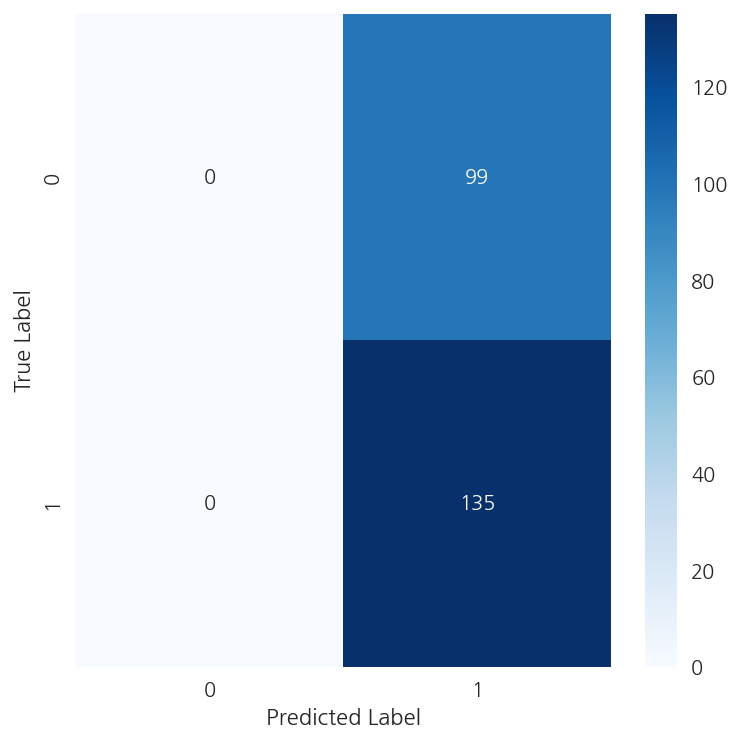

In [76]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. 분류 보고서 확인
print(classification_report(test['target'], backtest_df['p']))

# 2. 히트맵 시각화
plt.figure(figsize=(6, 6))
cm2 = confusion_matrix(test['target'], backtest_df['p'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

auc:0.7460905349794238


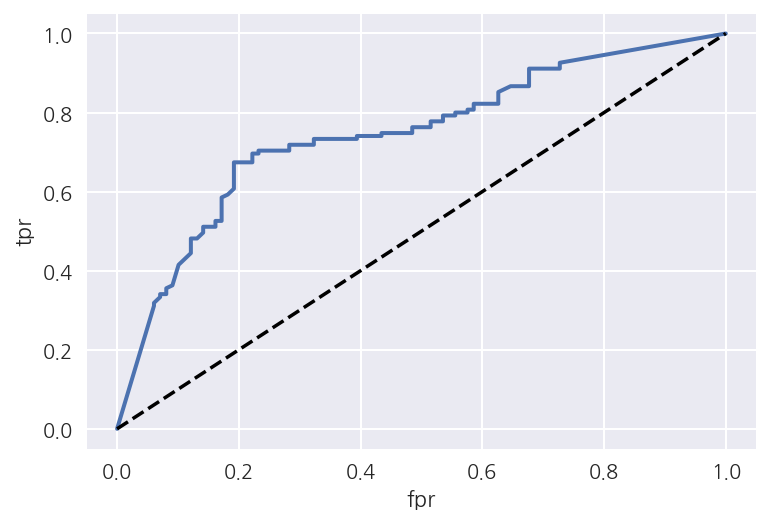

In [77]:
fpr, tpr, thresholds = roc_curve(test['target'], backtest_df['prob'])
auc = roc_auc_score(test['target'], backtest_df['prob'])
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

### 표본 외 경제적 성능 평가

In [78]:
# 매매 포지션 진입, 변경, 청산이 발생한 시점 횟수
sum(backtest_df['p'].diff() != 0) + 1

2

In [79]:
# 포지션 변경에 따른 증권사 수수료 / 거래세
pc = (0.00015 * 2  + 0.0018)

# 슬리피지 적용
sp = 0.001

In [80]:
backtest_df['p'] = np.where(backtest_df['p'] == 0, -1, 1)
backtest_df['r'] = df_test.loc[test.index]['r']
backtest_df['s'] = backtest_df['p'] * backtest_df['r']
backtest_df['s_'] = np.where(backtest_df['p'].diff() != 0,
                      backtest_df['s'] - pc - sp, backtest_df['s'])
backtest_df['s_'].iloc[0] -= pc
backtest_df['s_'].iloc[-1] -= pc
backtest_df

,prob,p,r,s,s_
Date,,,,,
2023-05-23,0.5567,1,4.0862e-03,4.0862e-03,-1.1138e-03
2023-05-24,0.5598,1,-3.8948e-05,-3.8948e-05,-3.8948e-05
2023-05-25,0.5605,1,-4.9823e-03,-4.9823e-03,-4.9823e-03
2023-05-26,0.5591,1,1.6114e-03,1.6114e-03,1.6114e-03
2023-05-30,0.5591,1,1.0384e-02,1.0384e-02,1.0384e-02
...,...,...,...,...,...
2024-04-29,0.5455,1,1.1644e-02,1.1644e-02,1.1644e-02
2024-04-30,0.5479,1,1.7176e-03,1.7176e-03,1.7176e-03
2024-05-02,0.5438,1,-3.1289e-03,-3.1289e-03,-3.1289e-03


In [81]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp)

r     1.0693
s     1.0693
s_    1.0616
dtype: float64

In [82]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp) - 1

r     0.0693
s     0.0693
s_    0.0616
dtype: float64

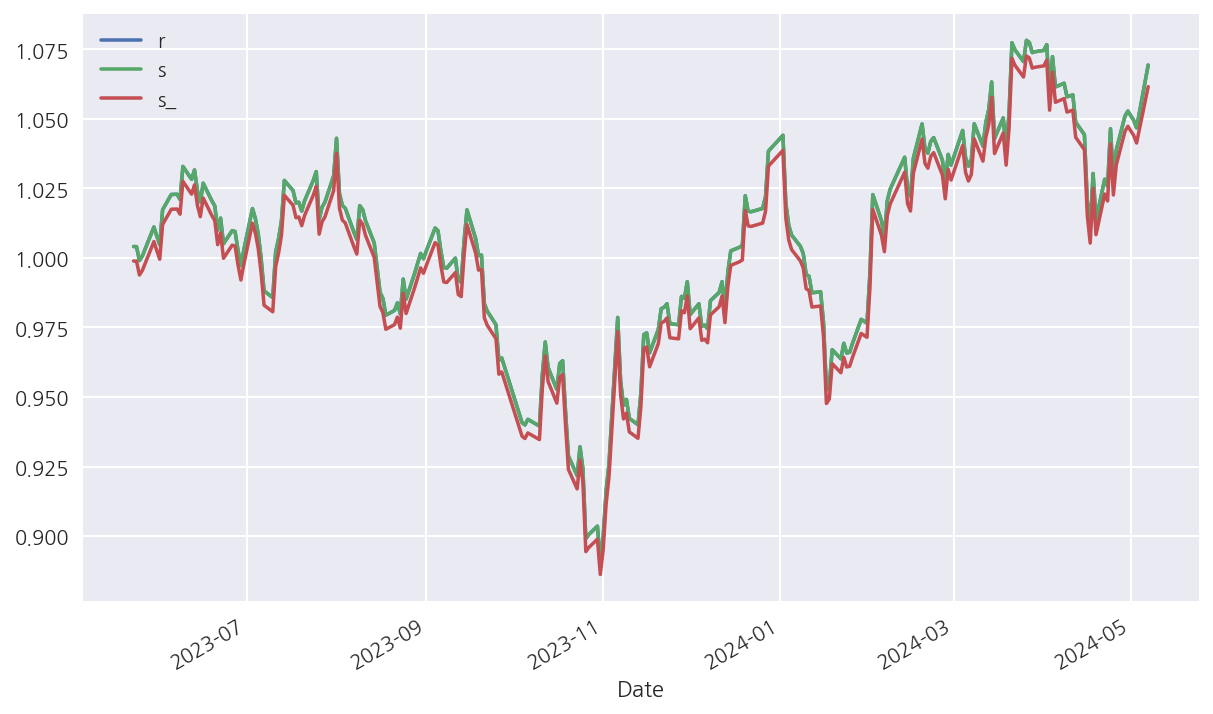

In [83]:
backtest_df[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### 예측 추세

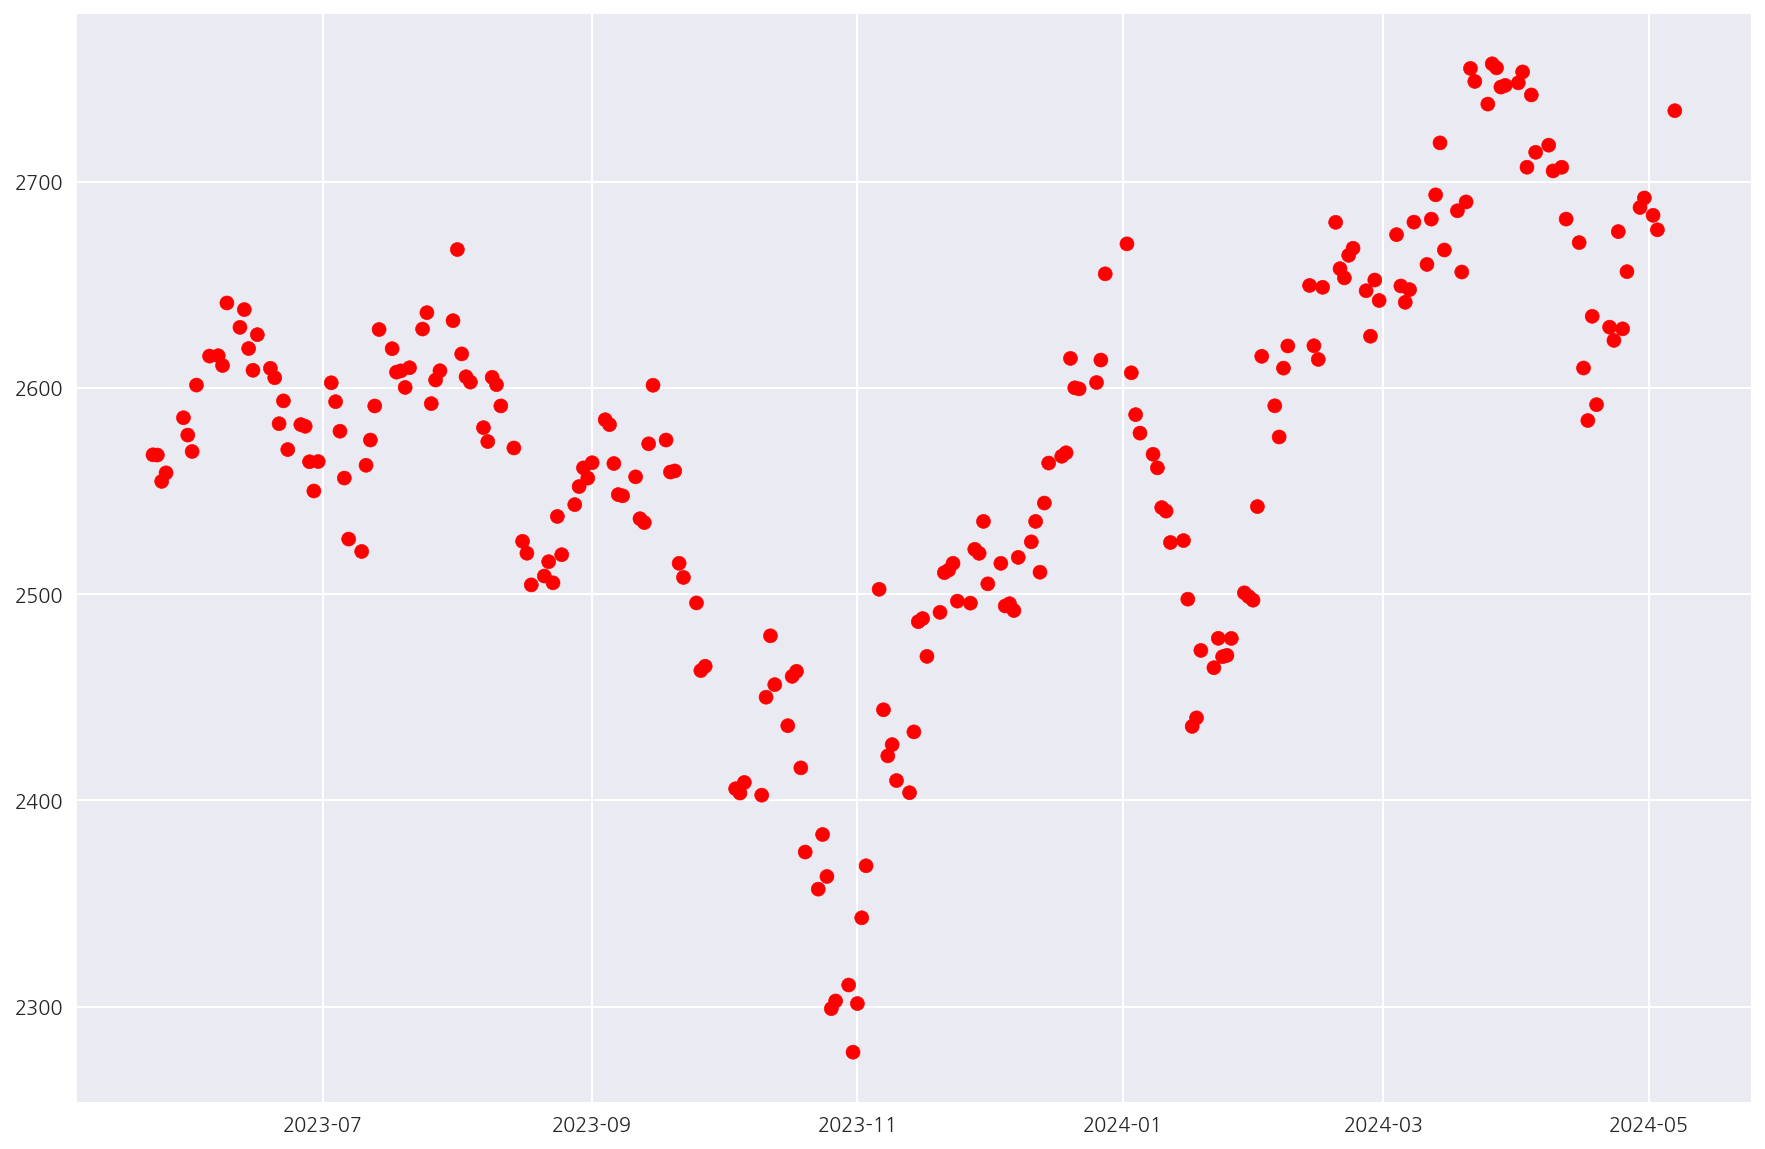

In [84]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = backtest_df['p']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### 실제 추세

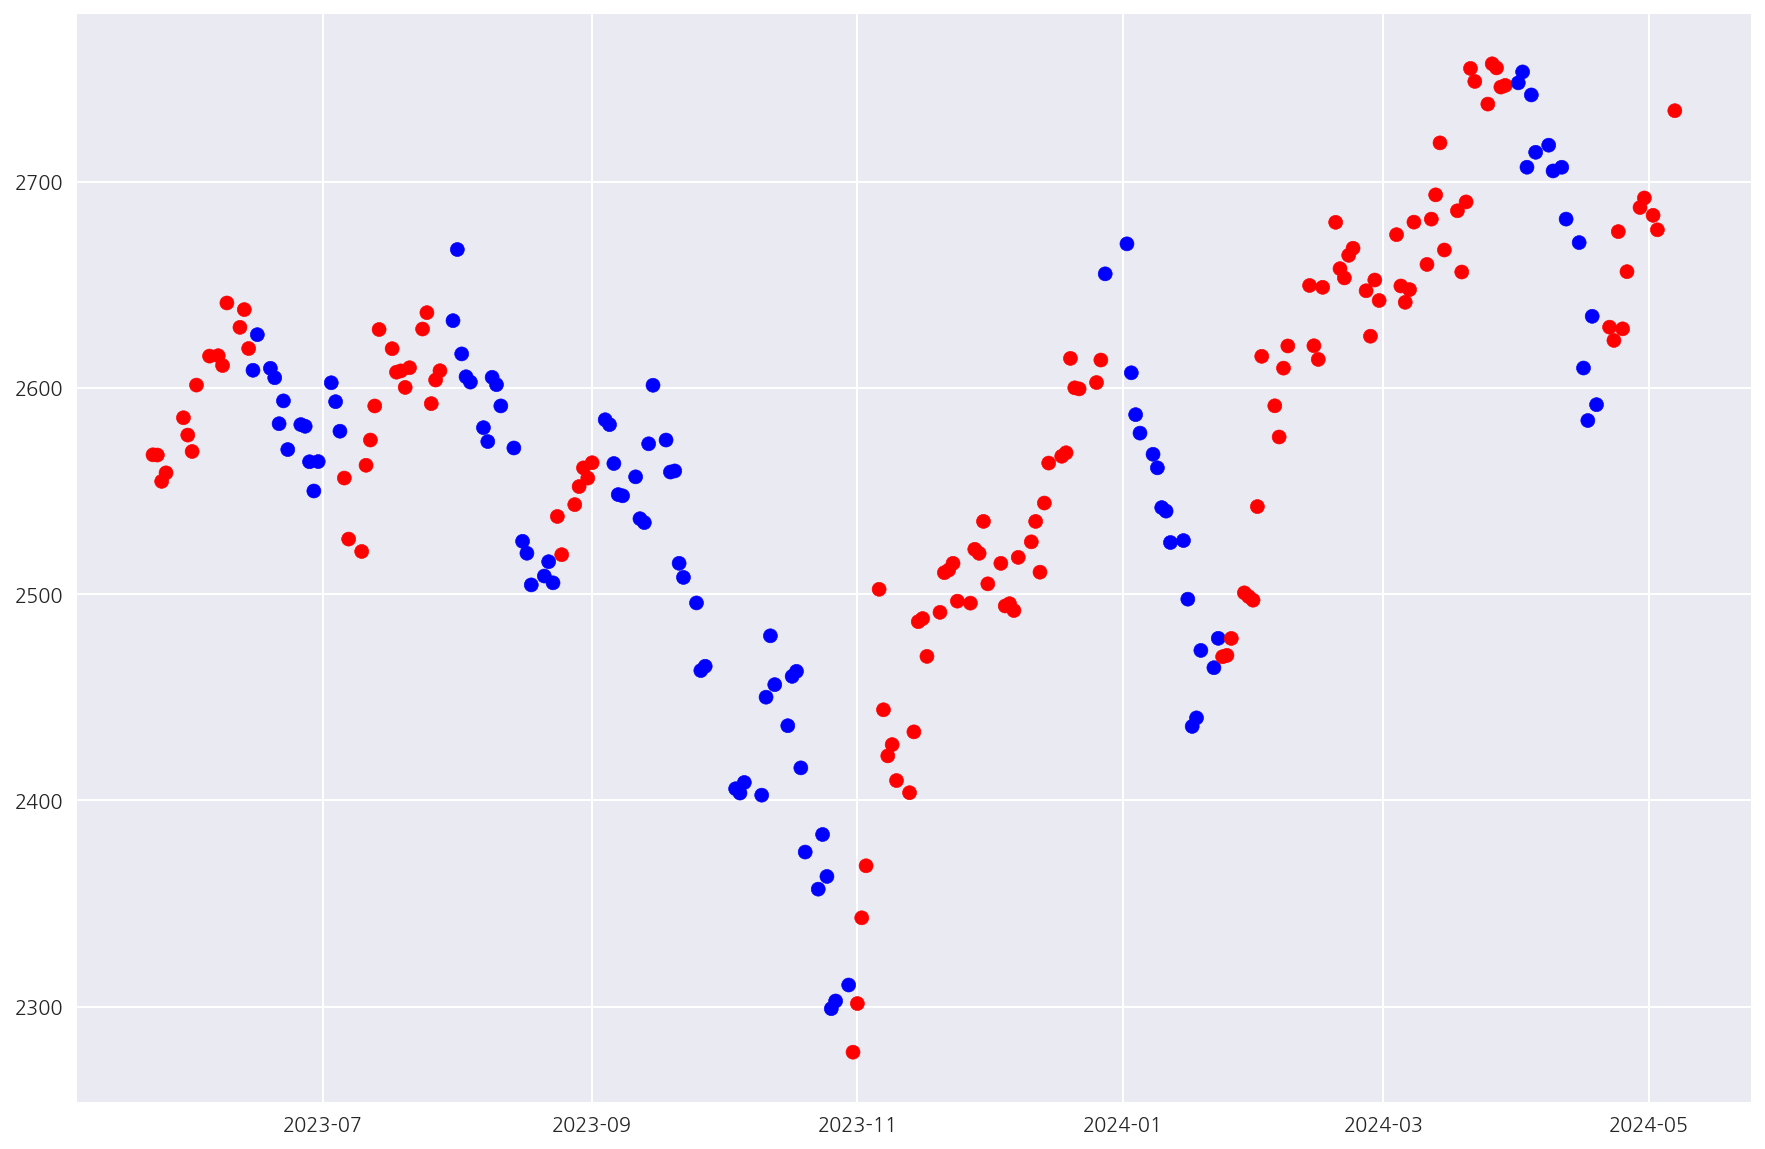

In [85]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = df_test['target'].loc[backtest_df['p'].index]
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### XGB

In [86]:
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [87]:
def eval_gini(y_true, y_pred):
    # 실제값과 예측값의 크기가 같은지 확인 (값이 다르면 오류 발생)
    assert y_true.shape == y_pred.shape

    n_samples = y_true.shape[0]                      # 데이터 개수
    L_mid = np.linspace(1 / n_samples, 1, n_samples) # 대각선 값

    # 1) 예측값에 대한 지니계수
    pred_order = y_true[y_pred.argsort()] # y_pred 크기순으로 y_true 값 정렬
    L_pred = np.cumsum(pred_order) / np.sum(pred_order) # 로렌츠 곡선
    G_pred = np.sum(L_mid - L_pred)       # 예측 값에 대한 지니계수

    # 2) 예측이 완벽할 때 지니계수
    true_order = y_true[y_true.argsort()] # y_true 크기순으로 y_true 값 정렬
    L_true = np.cumsum(true_order) / np.sum(true_order) # 로렌츠 곡선
    G_true = np.sum(L_mid - L_true)       # 예측이 완벽할 때 지니계수

    # 정규화된 지니계수
    return G_pred / G_true

In [88]:
# LightGBM용 gini() 함수
def gini(preds, dtrain):
    labels = dtrain.get_label()
    return 'gini', eval_gini(labels, preds), True # 반환값

In [89]:
# 시계열 데이터 분할 함수
def train_validation_split(df, test_size=0.2):
    
    split_index = int(len(df) * (1 - test_size))
    
    X_train = df[cols][:split_index]
    y_train = df['target'][:split_index]
    
    X_valid = df[cols][split_index:]
    y_valid = df['target'][split_index:]
    
    return X_train, X_valid, y_train, y_valid

# 데이터 분할
X_train, X_valid, y_train, y_valid = train_validation_split(train, test_size=0.2)

# 베이지안 최적화용 데이터셋
bayes_dtrain = xgb.DMatrix(X_train, y_train)
bayes_dvalid = xgb.DMatrix(X_valid, y_valid)

In [90]:
X_train

,Open_lag_0,Open_lag_1,Open_lag_2,Open_lag_3,Open_lag_4,Open_lag_5,Open_lag_6,Open_lag_7,Open_lag_8,Open_lag_9,...,s&p500_lag_5,s&p500_lag_6,s&p500_lag_7,s&p500_lag_8,s&p500_lag_9,s&p500_lag_10,s&p500_lag_11,s&p500_lag_12,s&p500_lag_13,s&p500_lag_14
Date,,,,,,,,,,,,,,,,,,,,,
2014-03-27,-0.5037,-0.5246,-0.5563,-0.5651,-0.5809,-0.5719,-0.5414,-0.5558,-0.6019,-0.6137,...,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563,-0.5503,-0.5497,-0.5504
2014-03-28,-0.4829,-0.5037,-0.5246,-0.5563,-0.5651,-0.5809,-0.5719,-0.5414,-0.5558,-0.6019,...,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563,-0.5503,-0.5497
2014-03-31,-0.4457,-0.4829,-0.5037,-0.5246,-0.5563,-0.5651,-0.5809,-0.5719,-0.5414,-0.5558,...,-0.5570,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563,-0.5503
2014-04-01,-0.4572,-0.4457,-0.4829,-0.5037,-0.5246,-0.5563,-0.5651,-0.5809,-0.5719,-0.5414,...,-0.5627,-0.5570,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559,-0.5563
2014-04-02,-0.4194,-0.4572,-0.4457,-0.4829,-0.5037,-0.5246,-0.5563,-0.5651,-0.5809,-0.5719,...,-0.5576,-0.5627,-0.5570,-0.5535,-0.5606,-0.5534,-0.5619,-0.5730,-0.5697,-0.5559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-01,2.5800,2.5585,2.5970,2.5974,2.5598,2.5420,2.5056,2.4595,2.5020,2.5055,...,0.9408,0.9437,0.9300,0.8932,0.9282,0.9293,0.9438,0.9492,0.9443,0.9391
2021-07-02,2.5451,2.5800,2.5585,2.5970,2.5974,2.5598,2.5420,2.5056,2.4595,2.5020,...,0.9563,0.9408,0.9437,0.9300,0.8932,0.9282,0.9293,0.9438,0.9492,0.9443
2021-07-05,2.5508,2.5451,2.5800,2.5585,2.5970,2.5974,2.5598,2.5420,2.5056,2.4595,...,0.9653,0.9563,0.9408,0.9437,0.9300,0.8932,0.9282,0.9293,0.9438,0.9492


In [91]:
y_train

Date
2014-03-27    1
2014-03-28    1
2014-03-31    1
2014-04-01    1
2014-04-02    1
             ..
2021-07-01    1
2021-07-02    0
2021-07-05    0
2021-07-06    0
2021-07-07    0
Name: target, Length: 1790, dtype: int64

In [92]:
X_valid

,Open_lag_0,Open_lag_1,Open_lag_2,Open_lag_3,Open_lag_4,Open_lag_5,Open_lag_6,Open_lag_7,Open_lag_8,Open_lag_9,...,s&p500_lag_5,s&p500_lag_6,s&p500_lag_7,s&p500_lag_8,s&p500_lag_9,s&p500_lag_10,s&p500_lag_11,s&p500_lag_12,s&p500_lag_13,s&p500_lag_14
Date,,,,,,,,,,,,,,,,,,,,,
2021-07-08,2.5563,2.5931,2.5743,2.5508,2.5451,2.5800,2.5585,2.5970,2.5974,2.5598,...,0.9759,0.9723,0.9715,0.9653,0.9563,0.9408,0.9437,0.9300,0.8932,0.9282
2021-07-09,2.4589,2.5563,2.5931,2.5743,2.5508,2.5451,2.5800,2.5585,2.5970,2.5974,...,0.9900,0.9759,0.9723,0.9715,0.9653,0.9563,0.9408,0.9437,0.9300,0.8932
2021-07-12,2.4173,2.4589,2.5563,2.5931,2.5743,2.5508,2.5451,2.5800,2.5585,2.5970,...,1.0105,0.9900,0.9759,0.9723,0.9715,0.9653,0.9563,0.9408,0.9437,0.9300
2021-07-13,2.4767,2.4173,2.4589,2.5563,2.5931,2.5743,2.5508,2.5451,2.5800,2.5585,...,1.0105,1.0105,0.9900,0.9759,0.9723,0.9715,0.9653,0.9563,0.9408,0.9437
2021-07-14,2.5157,2.4767,2.4173,2.4589,2.5563,2.5931,2.5743,2.5508,2.5451,2.5800,...,1.0049,1.0105,1.0105,0.9900,0.9759,0.9723,0.9715,0.9653,0.9563,0.9408
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24,0.8245,0.8669,0.8886,0.8978,0.9259,0.8984,0.9210,0.8161,0.8430,0.7898,...,0.8751,0.8805,0.8463,0.8570,0.8571,0.8545,0.8545,0.8453,0.8517,0.8668
2023-04-25,0.8083,0.8245,0.8669,0.8886,0.8978,0.9259,0.8984,0.9210,0.8161,0.8430,...,0.8837,0.8751,0.8805,0.8463,0.8570,0.8571,0.8545,0.8545,0.8453,0.8517
2023-04-26,0.7116,0.8083,0.8245,0.8669,0.8886,0.8978,0.9259,0.8984,0.9210,0.8161,...,0.8859,0.8837,0.8751,0.8805,0.8463,0.8570,0.8571,0.8545,0.8545,0.8453


In [93]:
y_valid

Date
2021-07-08    0
2021-07-09    0
2021-07-12    0
2021-07-13    0
2021-07-14    0
             ..
2023-04-24    0
2023-04-25    0
2023-04-26    0
2023-04-27    0
2023-04-28    0
Name: target, Length: 448, dtype: int64

In [94]:
# 베이지안 최적화를 위한 하이퍼파라미터 범위
param_bounds = {'max_depth': (1, 8),
                'subsample': (0.1, 0.9),
                'colsample_bytree': (0.1, 1.0),
                'min_child_weight': (1, 7),
                'gamma': (1, 11),
                'reg_alpha': (1, 9),
                'reg_lambda': (1.1, 1.5),
                'scale_pos_weight': (1.4, 1.6)}

# 값이 고정된 하이퍼파라미터
fixed_params = {'objective': 'binary:logistic',
                'eval_metric': 'error', # 
                'learning_rate': 0.02,
                'random_state': 1991}

In [95]:
def eval_function(max_depth, subsample, colsample_bytree, min_child_weight,
                 reg_alpha, gamma, reg_lambda, scale_pos_weight):
    '''최적화하려는 평가지표(지니계수) 계산 함수'''
    # 베이지안 최적화를 수행할 하이퍼파라미터
    params = {'max_depth': int(round(max_depth)),
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'min_child_weight': min_child_weight,
              'gamma': gamma,
              'reg_alpha':reg_alpha,
              'reg_lambda': reg_lambda,
              'scale_pos_weight': scale_pos_weight}
    # 값이 고정된 하이퍼파라미터도 추가
    params.update(fixed_params)
    
    print('하이퍼파라미터 :', params)    
        
    # XGBoost 모델 훈련
    xgb_model = xgb.train(params=params, 
                          dtrain=bayes_dtrain,
                          num_boost_round=2000,
                          evals=[(bayes_dvalid, 'bayes_dvalid')],
                          maximize=True,
                          #feval=gini,
                          early_stopping_rounds=200,
                          verbose_eval=False)
                           
    best_iter = xgb_model.best_iteration # 최적 반복 횟수
    # 검증 데이터로 예측 수행
    preds = xgb_model.predict(bayes_dvalid, 
                              iteration_range=(0, best_iter))
    # 지니계수 계산
    gini_score = eval_gini(y_valid, preds)
    print(f'지니계수 : {gini_score}\n')
    
    return gini_score

In [96]:
# 베이지안 최적화 객체 생성
optimizer = BayesianOptimization(f=eval_function, 
                                 pbounds=param_bounds, 
                                 random_state=0)

# 베이지안 최적화 수행
optimizer.maximize(init_points=3, n_iter=6)

|   iter    |  target   | colsam... |   gamma   | max_depth | min_ch... | reg_alpha | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------
하이퍼파라미터 : {'max_depth': 5, 'subsample': 0.8134184006256638, 'colsample_bytree': 0.5939321535345923, 'min_child_weight': 4.269299097981381, 'gamma': 8.151893663724195, 'reg_alpha': 4.389238394711238, 'reg_lambda': 1.3583576452266626, 'scale_pos_weight': 1.4875174422525386, 'objective': 'binary:logistic', 'eval_metric': 'error', 'learning_rate': 0.02, 'random_state': 1991}
지니계수 : 0.5987592777223884

| 1         | 0.5988    | 0.5939    | 8.152     | 5.219     | 4.269     | 4.389     | 1.358     | 1.488     | 0.8134    |
하이퍼파라미터 : {'max_depth': 7, 'subsample': 0.1697034397612326, 'colsample_bytree': 0.9672964844509263, 'min_child_weight': 4.173369518517427, 'gamma': 4.834415188257777, 'reg_alpha': 5.5443564887514585, 'reg_lambda': 1.4702386553170643,

In [97]:
# 평가함수 점수가 최대일 때 하이퍼파라미터
max_params = optimizer.max['params']
max_params

{'colsample_bytree': 0.9672964844509263,
 'gamma': 4.834415188257777,
 'max_depth': 6.542075266578652,
 'min_child_weight': 4.173369518517427,
 'reg_alpha': 5.5443564887514585,
 'reg_lambda': 1.4702386553170643,
 'scale_pos_weight': 1.4142072116395774,
 'subsample': 0.1697034397612326}

In [98]:
# 정수형 하이퍼파라미터 변환
max_params['max_depth'] = int(round(max_params['max_depth']))

In [99]:
# 값이 고정된 하이퍼파라미터 추가
max_params.update(fixed_params)
max_params

{'colsample_bytree': 0.9672964844509263,
 'gamma': 4.834415188257777,
 'max_depth': 7,
 'min_child_weight': 4.173369518517427,
 'reg_alpha': 5.5443564887514585,
 'reg_lambda': 1.4702386553170643,
 'scale_pos_weight': 1.4142072116395774,
 'subsample': 0.1697034397612326,
 'objective': 'binary:logistic',
 'eval_metric': 'error',
 'learning_rate': 0.02,
 'random_state': 1991}

In [100]:
from sklearn.model_selection import TimeSeriesSplit, KFold

# K 폴드 교차 검증기 생성
# folds = TimeSeriesSplit(n_splits=4)
folds = KFold(n_splits=4, shuffle=False)

X = train[cols]
X_test = test[cols]
y = train['target'].values

# OOF 방식으로 훈련된 모델로 검증 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_val_preds = np.zeros(X.shape[0]) 
# OOF 방식으로 훈련된 모델로 테스트 데이터 타깃값을 예측한 확률을 담을 1차원 배열
oof_test_preds = np.zeros(X_test.shape[0]) 

# OOF 방식으로 모델 훈련, 검증, 예측
for idx, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    # 각 폴드를 구분하는 문구 출력
    print('#'*40, f'폴드 {idx+1} / 폴드 {folds.n_splits}', '#'*40)
    
    # 훈련용 데이터, 검증용 데이터 설정
    X_train, y_train = X.iloc[train_idx], y[train_idx] # 훈련용 데이터
    X_valid, y_valid = X.iloc[valid_idx], y[valid_idx] # 검증용 데이터
    
    # XGBoost 전용 데이터셋 생성 
    dtrain = xgb.DMatrix(X_train, y_train)
    dvalid = xgb.DMatrix(X_valid, y_valid)
    dtest = xgb.DMatrix(X_test)
    # XGBoost 모델 훈련
    xgb_model = xgb.train(params=max_params, 
                          dtrain=dtrain,
                          num_boost_round=2000,
                          evals=[(dvalid, 'valid')],
                          maximize=True,
                          #feval=gini,
                          early_stopping_rounds=200,
                          verbose_eval=100)

    # 모델 성능이 가장 좋을 때의 부스팅 반복 횟수 저장
    best_iter = xgb_model.best_iteration
    # 테스트 데이터를 활용해 OOF 예측
    oof_test_preds += xgb_model.predict(dtest,
                                        iteration_range=(0, best_iter))/folds.n_splits
    
    # 모델 성능 평가를 위한 검증 데이터 타깃값 예측 
    oof_val_preds[valid_idx] += xgb_model.predict(dvalid, 
                                                  iteration_range=(0, best_iter))
    
    # 검증 데이터 예측 확률에 대한 정규화 지니계수
    gini_score = eval_gini(y_valid, oof_val_preds[valid_idx])
    print(f'폴드 {idx+1} 지니계수 : {gini_score}\n')

######################################## 폴드 1 / 폴드 4 ########################################
[0]	valid-error:0.28036
[100]	valid-error:0.26250
[200]	valid-error:0.28571
[300]	valid-error:0.30357
[400]	valid-error:0.31071
[500]	valid-error:0.31071
[600]	valid-error:0.31964
[700]	valid-error:0.31964
[762]	valid-error:0.31964
폴드 1 지니계수 : 0.618145433754353

######################################## 폴드 2 / 폴드 4 ########################################
[0]	valid-error:0.33393
[100]	valid-error:0.20536
[199]	valid-error:0.20893
폴드 2 지니계수 : 0.703509677077959

######################################## 폴드 3 / 폴드 4 ########################################
[0]	valid-error:0.21646
[100]	valid-error:0.20215
[199]	valid-error:0.20751
폴드 3 지니계수 : 0.6841715976331361

######################################## 폴드 4 / 폴드 4 ########################################
[0]	valid-error:0.33810
[100]	valid-error:0.25939
[200]	valid-error:0.24866
폴드 4 지니계수 : 0.6390119160603185



In [101]:
print('OOF 검증 데이터 지니계수 :', eval_gini(y, oof_val_preds))

OOF 검증 데이터 지니계수 : 0.6426869507383757


In [102]:
oof_test_preds

array([0.7928, 0.8022, 0.7714, 0.7931, 0.8105, 0.8206, 0.7759, 0.8322,
       0.8356, 0.8425, 0.837 , 0.8563, 0.8484, 0.8658, 0.8146, 0.7507,
       0.7892, 0.7317, 0.6382, 0.352 , 0.4528, 0.2174, 0.2877, 0.3052,
       0.1768, 0.1611, 0.201 , 0.4749, 0.3738, 0.2095, 0.1348, 0.1085,
       0.1226, 0.1934, 0.3699, 0.5261, 0.6389, 0.6951, 0.6232, 0.679 ,
       0.6495, 0.6985, 0.7387, 0.7185, 0.3631, 0.5229, 0.6024, 0.7571,
       0.7735, 0.4988, 0.3917, 0.3466, 0.229 , 0.2251, 0.3716, 0.321 ,
       0.2129, 0.1561, 0.1447, 0.1553, 0.1545, 0.1693, 0.1787, 0.1578,
       0.1893, 0.16  , 0.1842, 0.2246, 0.3153, 0.2984, 0.3726, 0.5859,
       0.6565, 0.5027, 0.3652, 0.3962, 0.5651, 0.4174, 0.4096, 0.767 ,
       0.8231, 0.7403, 0.521 , 0.4747, 0.192 , 0.1832, 0.1598, 0.1201,
       0.1419, 0.1273, 0.1128, 0.127 , 0.124 , 0.1861, 0.2713, 0.155 ,
       0.1374, 0.1637, 0.2063, 0.1574, 0.1484, 0.1561, 0.1955, 0.2166,
       0.1871, 0.1754, 0.2204, 0.2017, 0.2267, 0.2635, 0.3425, 0.7448,
      

### 결과 보고서

In [103]:
backtest_df = pd.DataFrame(index=test.index)
backtest_df['prob'] = oof_test_preds
backtest_df['p'] = (backtest_df['prob'] > 0.5).astype(int)

In [104]:
# 예측값 비율
backtest_df['p'].value_counts()

1    128
0    106
Name: p, dtype: int64

In [105]:
# 실제값 비율
test['target'].value_counts()

1    135
0     99
Name: target, dtype: int64

              precision    recall  f1-score   support

           0       0.69      0.74      0.71        99
           1       0.80      0.76      0.78       135

    accuracy                           0.75       234
   macro avg       0.74      0.75      0.74       234
weighted avg       0.75      0.75      0.75       234



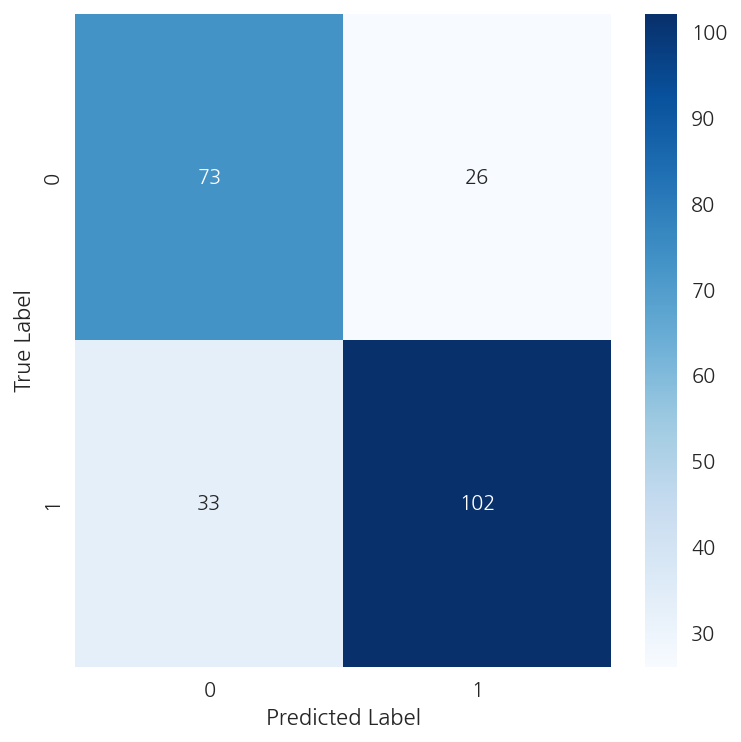

In [106]:
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. 분류 보고서 확인
print(classification_report(test['target'], backtest_df['p']))

# 2. 히트맵 시각화
plt.figure(figsize=(6, 6))
cm2 = confusion_matrix(test['target'], backtest_df['p'])
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

auc:0.7993265993265993


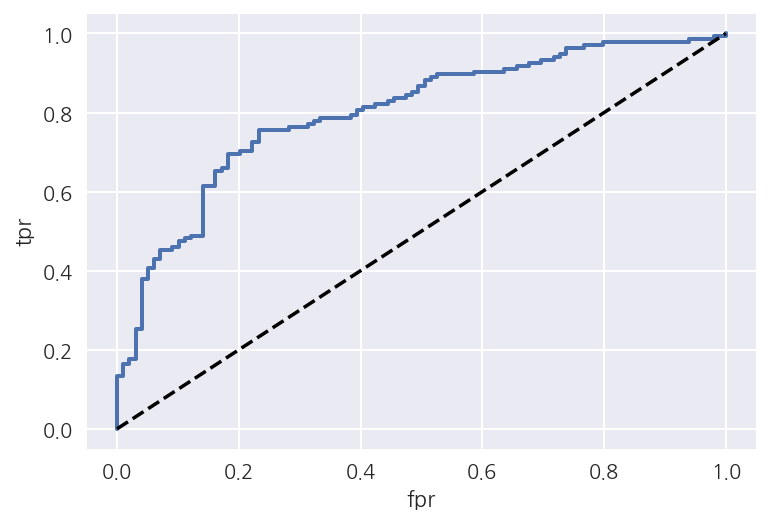

In [107]:
fpr, tpr, thresholds = roc_curve(test['target'], backtest_df['prob'])
auc = roc_auc_score(test['target'], backtest_df['prob'])
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

### 표본 외 경제적 성능 평가

In [108]:
# 매매 포지션 진입, 변경, 청산이 발생한 시점 횟수
sum(backtest_df['p'].diff() != 0) + 1

20

In [109]:
# 포지션 변경에 따른 증권사 수수료 / 거래세
pc = (0.00015 * 2  + 0.0018)

# 슬리피지 적용
sp = 0.001

In [110]:
backtest_df['p'] = np.where(backtest_df['p'] == 0, -1, 1)
backtest_df['r'] = df_test.loc[test.index]['r']
backtest_df['s'] = backtest_df['p'] * backtest_df['r']
backtest_df['s_'] = np.where(backtest_df['p'].diff() != 0,
                      backtest_df['s'] - pc - sp, backtest_df['s'])
backtest_df['s_'].iloc[0] -= pc
backtest_df['s_'].iloc[-1] -= pc
backtest_df

,prob,p,r,s,s_
Date,,,,,
2023-05-23,0.7928,1,4.0862e-03,4.0862e-03,-1.1138e-03
2023-05-24,0.8022,1,-3.8948e-05,-3.8948e-05,-3.8948e-05
2023-05-25,0.7714,1,-4.9823e-03,-4.9823e-03,-4.9823e-03
2023-05-26,0.7931,1,1.6114e-03,1.6114e-03,1.6114e-03
2023-05-30,0.8105,1,1.0384e-02,1.0384e-02,1.0384e-02
...,...,...,...,...,...
2024-04-29,0.4484,-1,1.1644e-02,-1.1644e-02,-1.1644e-02
2024-04-30,0.4827,-1,1.7176e-03,-1.7176e-03,-1.7176e-03
2024-05-02,0.4338,-1,-3.1289e-03,3.1289e-03,3.1289e-03


In [111]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp)

r     1.0693
s     1.6427
s_    1.5422
dtype: float64

In [112]:
backtest_df[['r', 's', 's_']].sum().apply(np.exp) - 1

r     0.0693
s     0.6427
s_    0.5422
dtype: float64

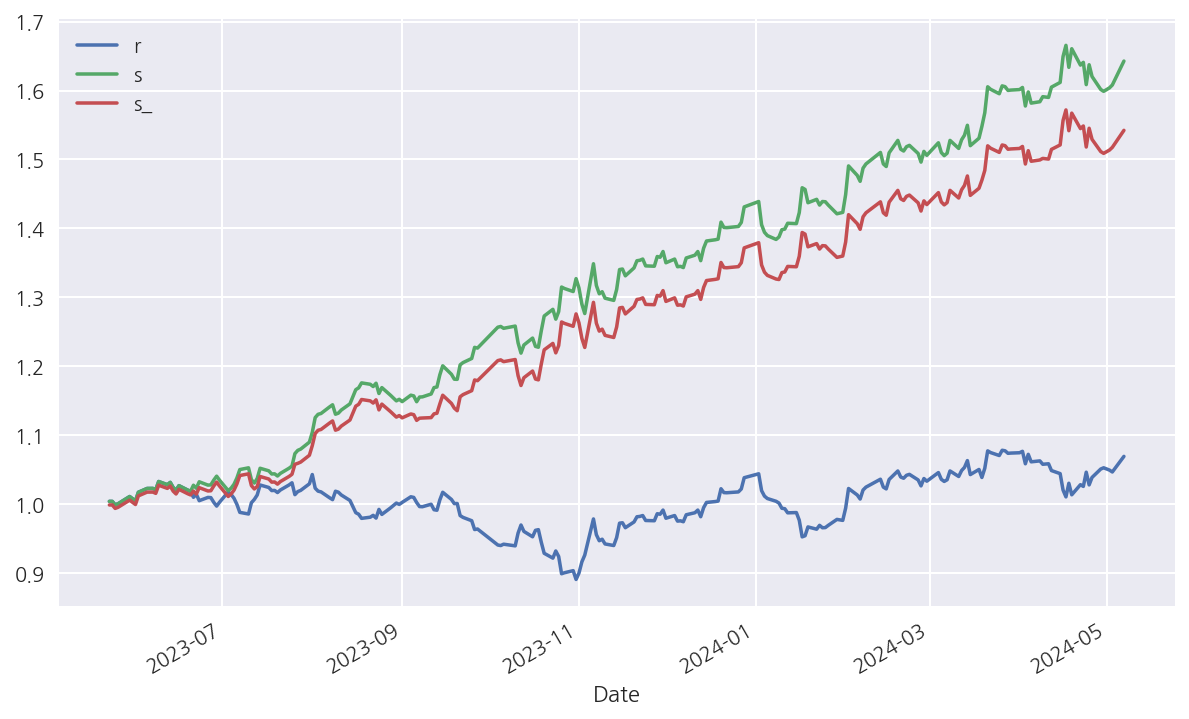

In [113]:
backtest_df[['r', 's', 's_']].cumsum().apply(np.exp).plot(figsize=(10, 6));

### 예측 추세

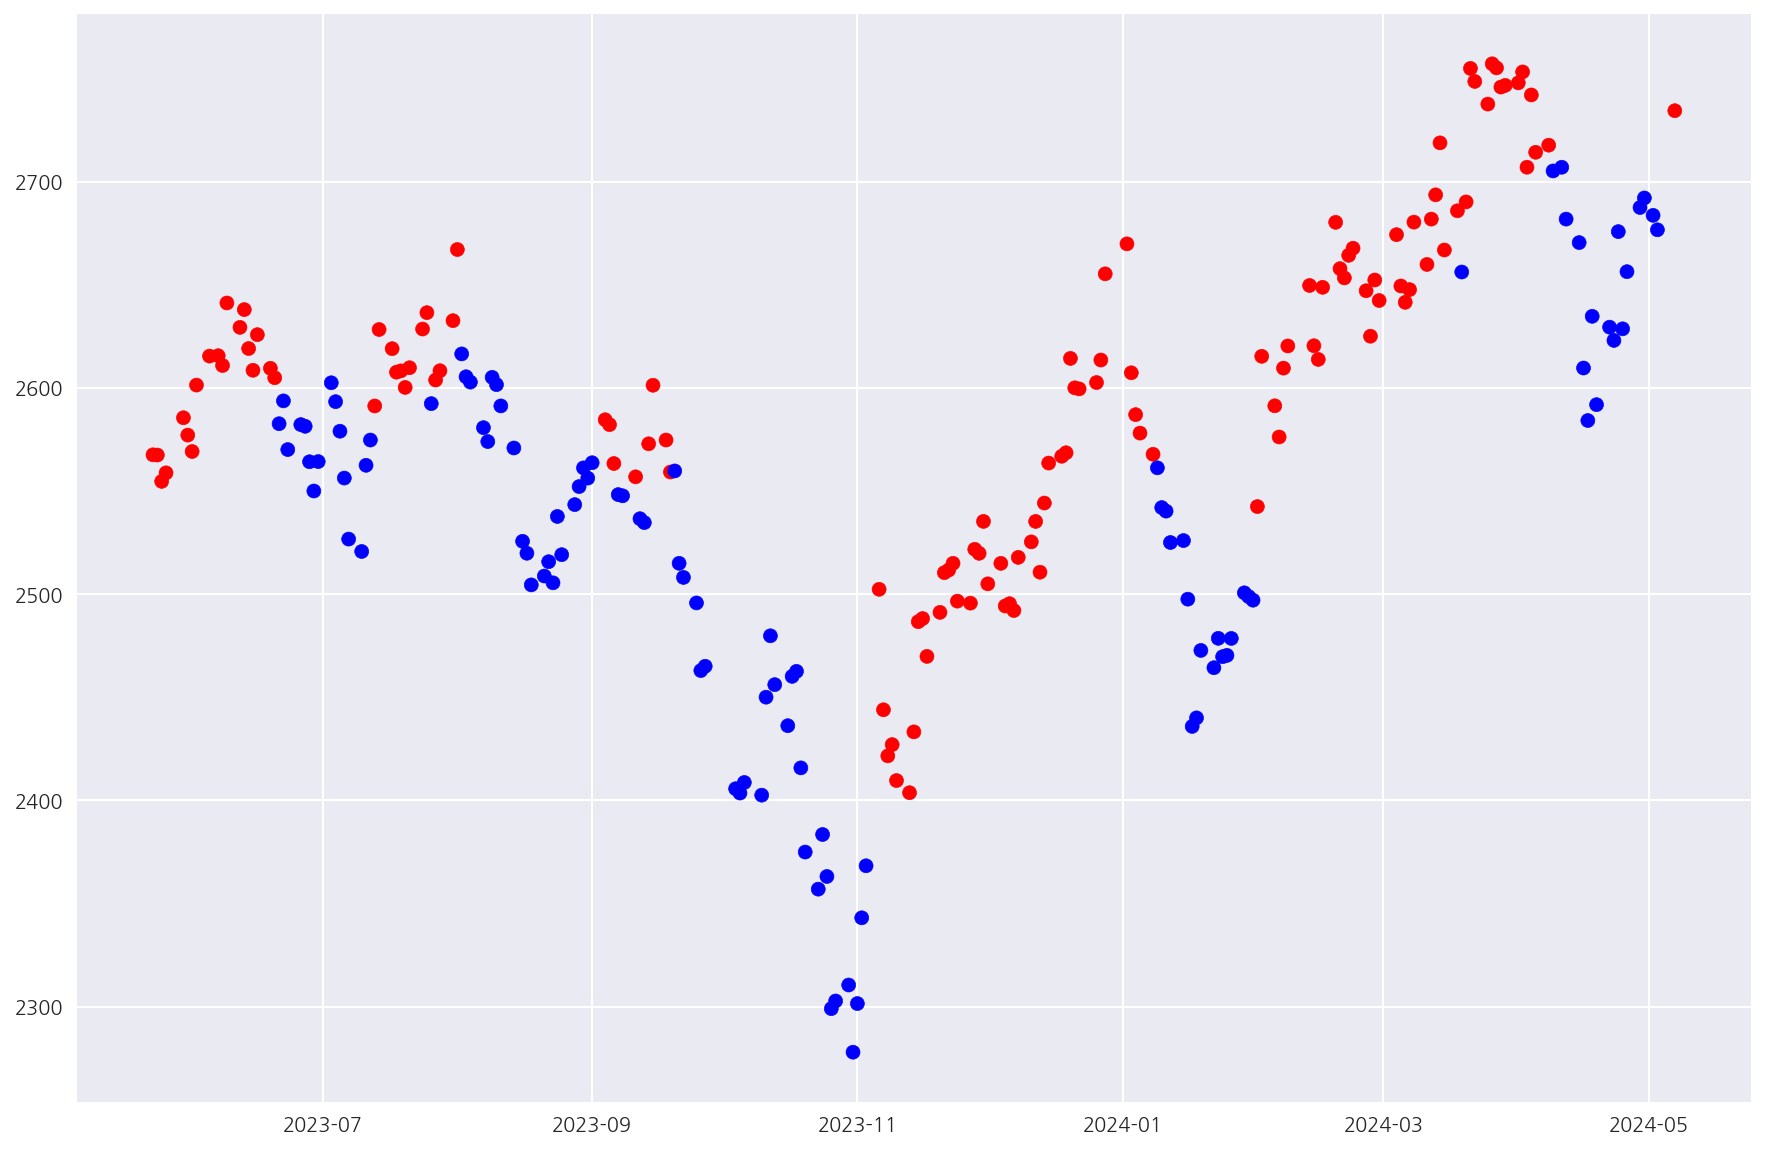

In [114]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = backtest_df['p']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])

### 실제 추세

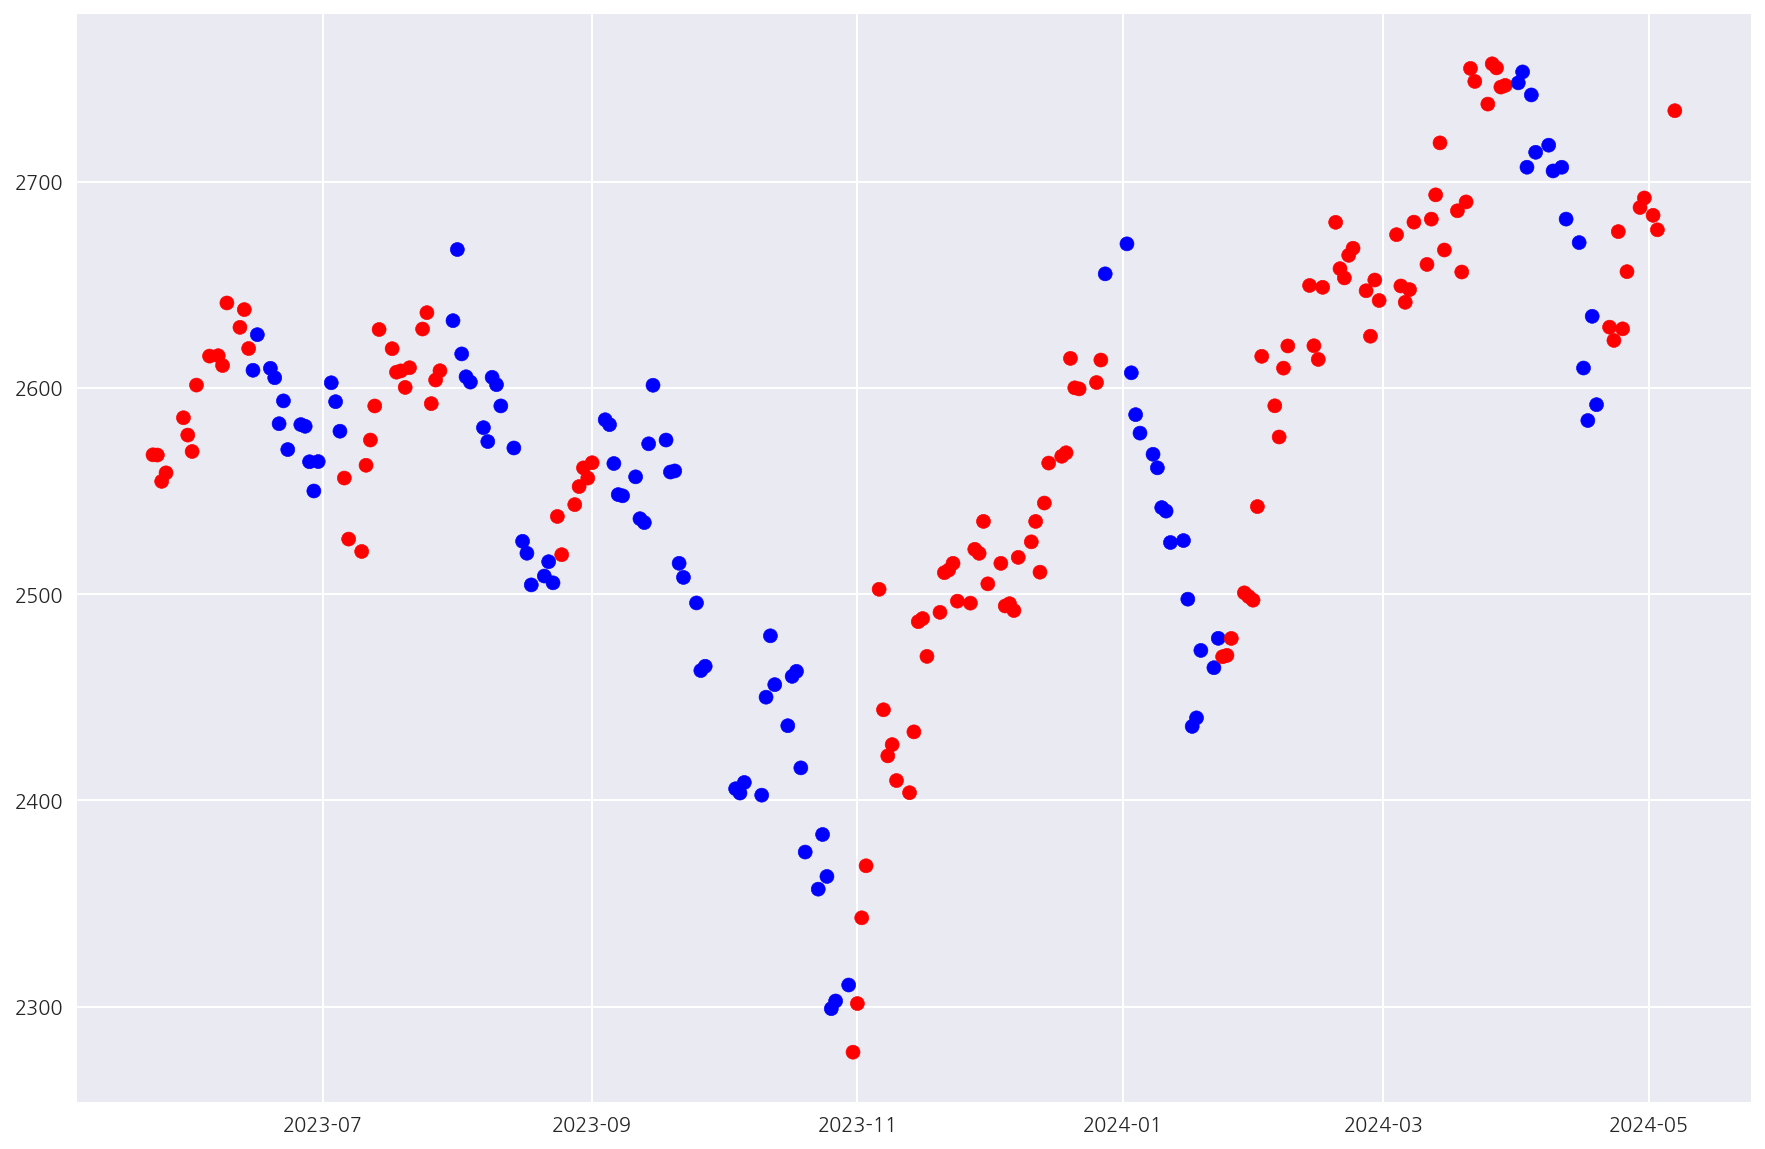

In [115]:
sub_data = df_test['Close'].loc[backtest_df['p'].index]
c_sig = df_test['target'].loc[backtest_df['p'].index]
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.scatter(sub_data.index, sub_data.values,
              c=c_sig['color'])